# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from yellowbrick.classifier import ROCAUC


sys.path.insert(0, r"d:\ML\Fake News Detection")
from src.data_audit import DataAudit


In [3]:
PATH_TO_DATA = r"d:\ML\Fake News Detection\data\liar_processed.csv"
data = pd.read_csv(PATH_TO_DATA)
print(data.shape)

(12791, 18)


In [4]:
train = pd.read_csv(r"d:\ML\Fake News Detection\data\train.csv")
test = pd.read_csv(r"d:\ML\Fake News Detection\data\test.csv")
valid = pd.read_csv(r"d:\ML\Fake News Detection\data\valid.csv")

In [5]:
X_train = train.drop(columns=['label'])
y_train = train['label']
X_valid = valid.drop(columns=['label'])
y_valid = valid['label']
X_test = test.drop(columns=['label'])
y_test = test['label']
X_combined = pd.concat([X_train, X_valid], axis=0)
y_combined = pd.concat([y_train, y_valid], axis=0)
split_indices = np.concatenate([
    -1 * np.ones(X_train.shape[0]), 
     0 * np.ones(X_valid.shape[0]) 
])

split = PredefinedSplit(test_fold=split_indices)

In [6]:
def grid_search(X, y, pipeline):
    param_grid = {
        'classifier__n_estimators': [100, 200, 300, 400],
        'classifier__max_features': ['sqrt', 'log2', None],
        'classifier__n_jobs': [-1]
    }
    grid_search = GridSearchCV(pipeline,
                               param_grid,
                               cv=split,
                               scoring='f1_weighted',
                               n_jobs=-1)
    grid_search.fit(X, y)
    return grid_search.best_estimator_, grid_search.best_params_

In [7]:
def plot_feature_importances(model):
    clf = model.named_steps["classifier"]
    pre = model.named_steps["preprocessor"]
    feature_names = pre.get_feature_names_out()
    importances = pd.Series(clf.feature_importances_, index=feature_names).sort_values(ascending=True)
    importances = importances.tail(25)
    plt.figure(figsize=(30, 25))
    sns.barplot(x=importances.index, y=importances.values)
    plt.title("Top Feature Importances", fontsize=20)
    plt.xlabel("Importance", fontsize=16)
    plt.ylabel("Feature", fontsize=16)
    plt.xticks(rotation=45, fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    plt.show()

In [8]:
predictions = len(data) * [3]
accuracy = accuracy_score(data['label'], predictions)
precision = precision_score(data['label'],
                            predictions,
                            average='weighted',
                            zero_division=0)
recall = recall_score(data['label'],
                      predictions,
                      average='weighted',
                      zero_division=0)
f1 = f1_score(data['label'], predictions, average='weighted', zero_division=0)
report = []
report.append({
    "model": "Baseline(predicting the most common class)",
    "n_estimators": None,
    "max_features": None,
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
})

In [9]:
def calculate_metrics(y_true, y_pred, model_name, model):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    clf = model.named_steps["classifier"]
    report.append({
        "model": model_name,
        "n_estimators": clf.get_params().get("n_estimators"),
        "max_features": clf.get_params().get("max_features"),
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    })
    print(f"F1 Score: {f1:.3f}")

In [10]:
def save_to_excel(report, filename='decision_tree_report.xlsx'):
    df_report = pd.DataFrame(report)
    df_report.to_excel(filename, index=False)

We will first try to see what we can get without the statement column

F1 Score: 0.617


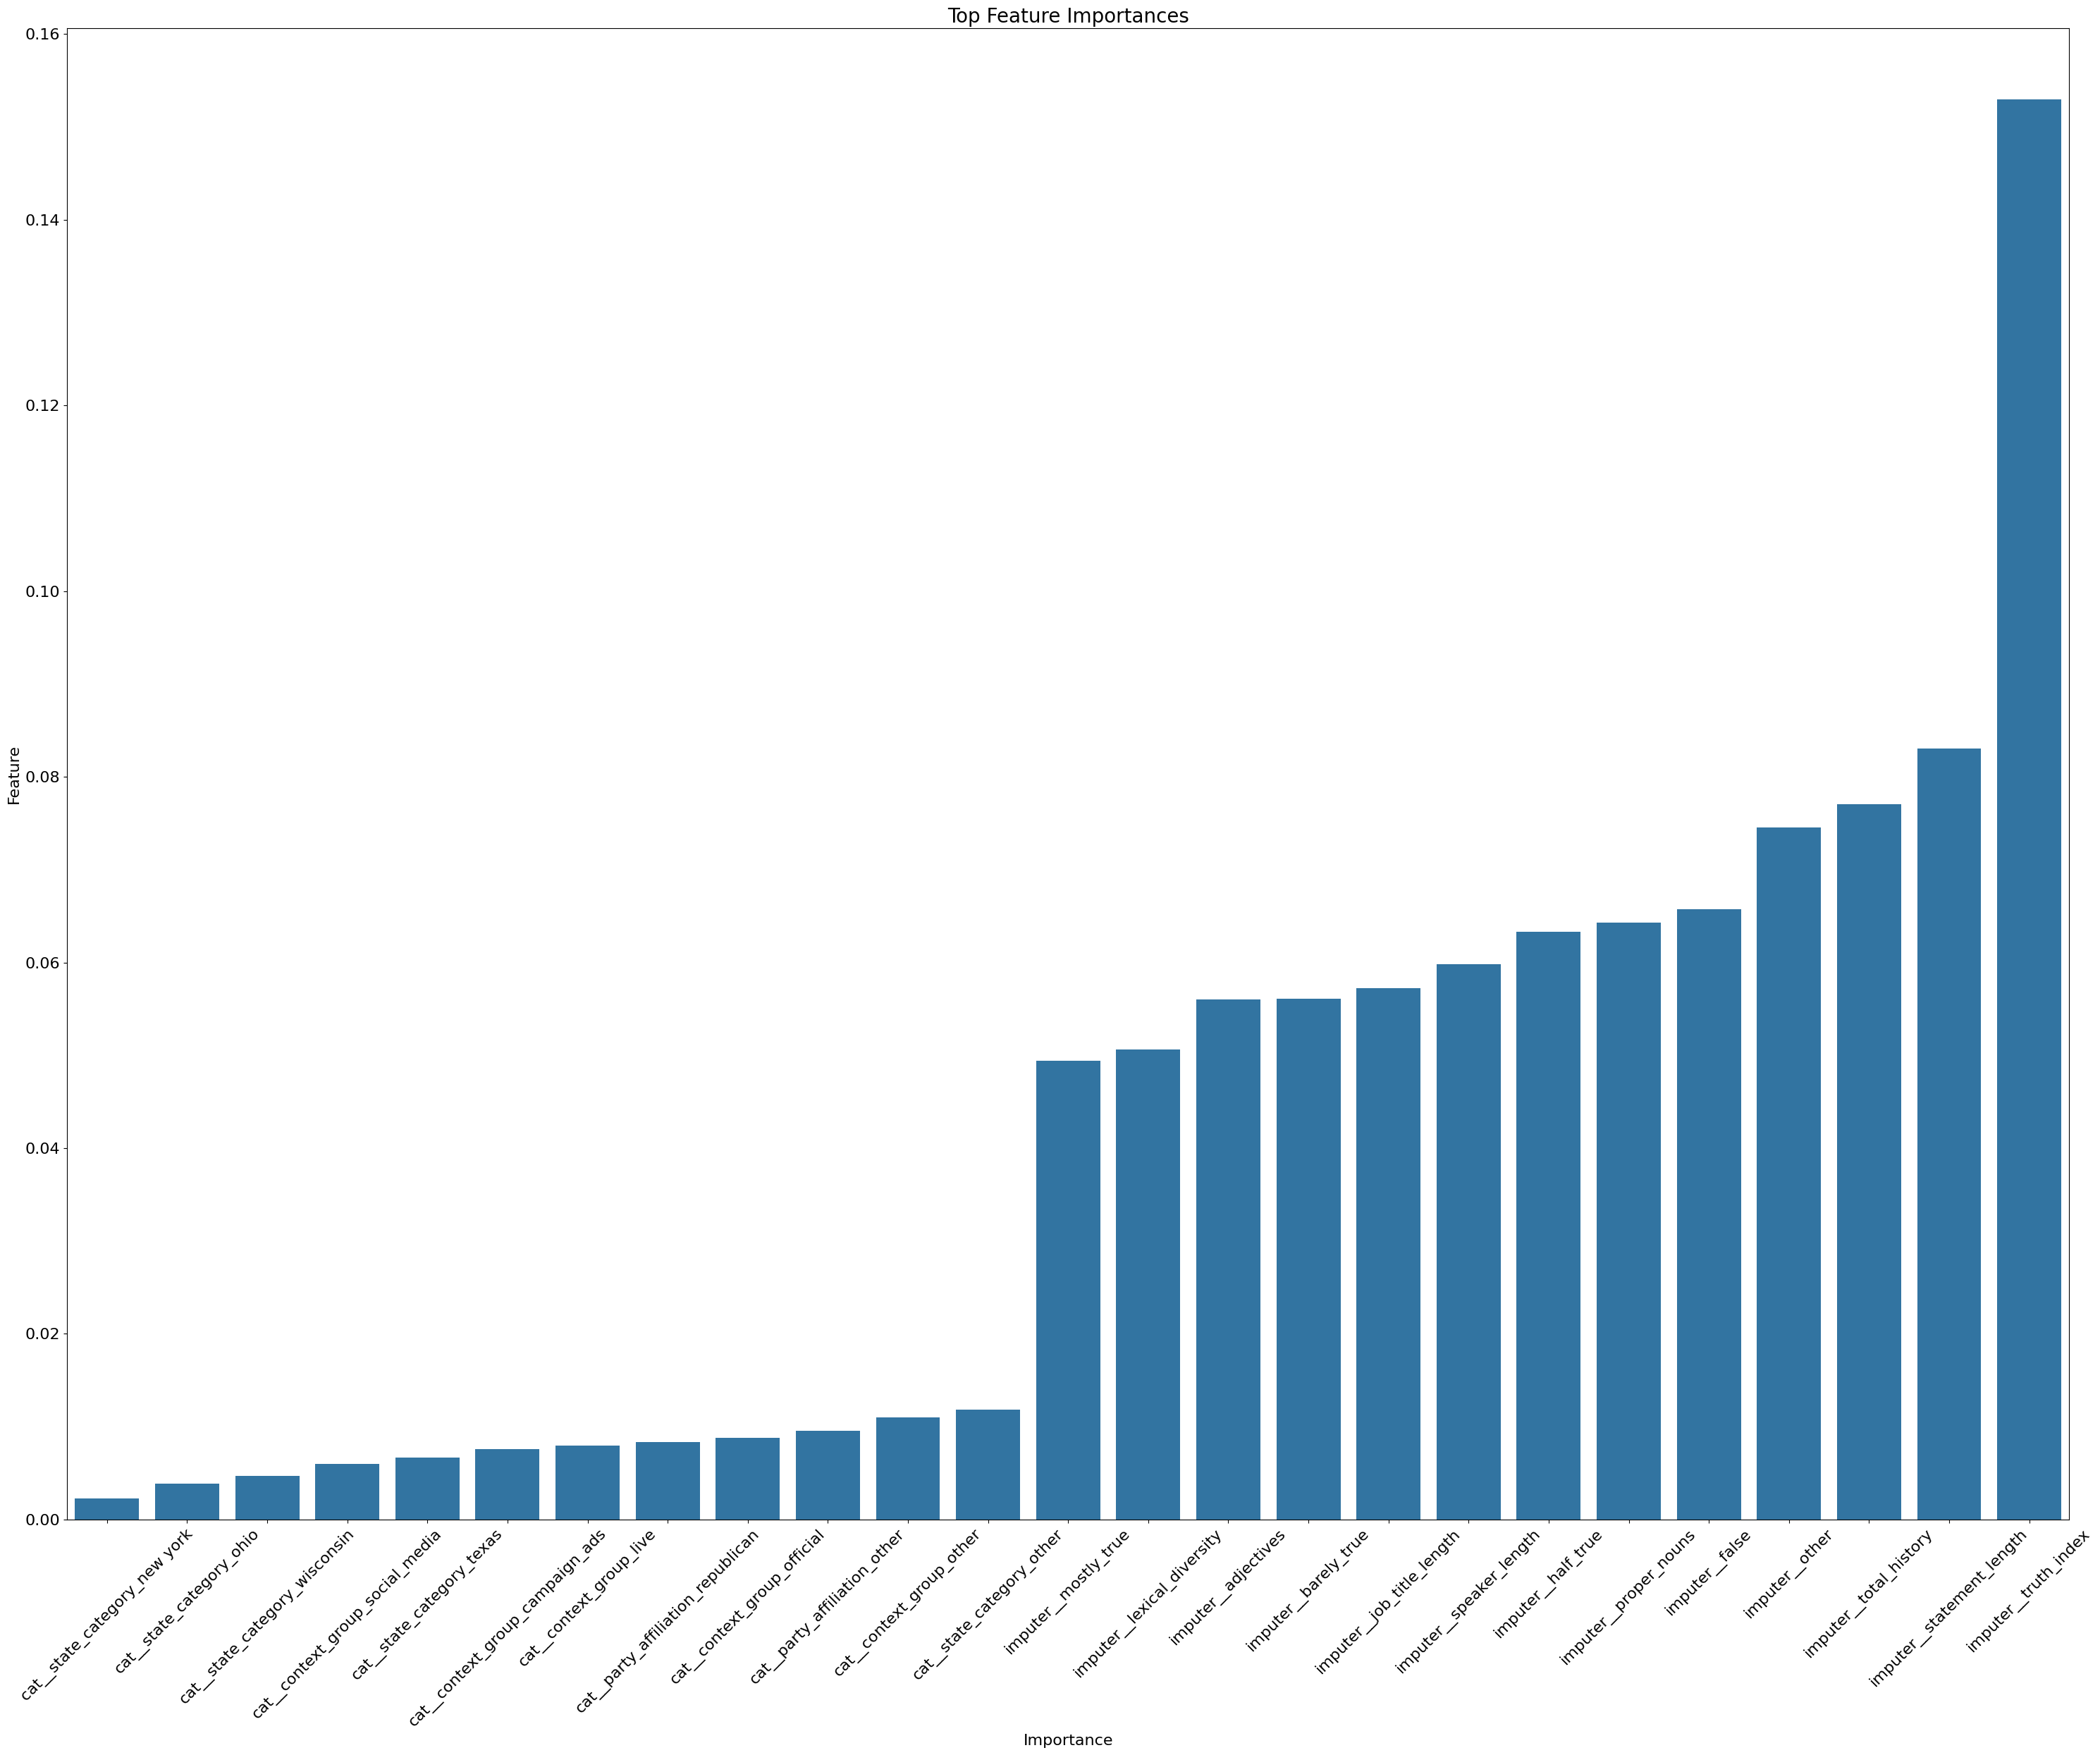

In [52]:
categorical_cols = ['context_group', 'state_category', 'party_affiliation']
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop = 'first'), categorical_cols),
        ('imputer', SimpleImputer(strategy='median'), numerical_cols)
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
model = grid_search(X_combined.drop(columns=['statement']), y_combined, pipeline)[0]
calculate_metrics(y_test, model.predict(X_test.drop(columns=['statement'])), "RandomForest", model)
plot_feature_importances(model)

We see a 0.617 f1 score, which beats the best decision tree model in the previous experiments. Again, let us try remove the column with the least impact, which is cat_state category

F1 Score: 0.611


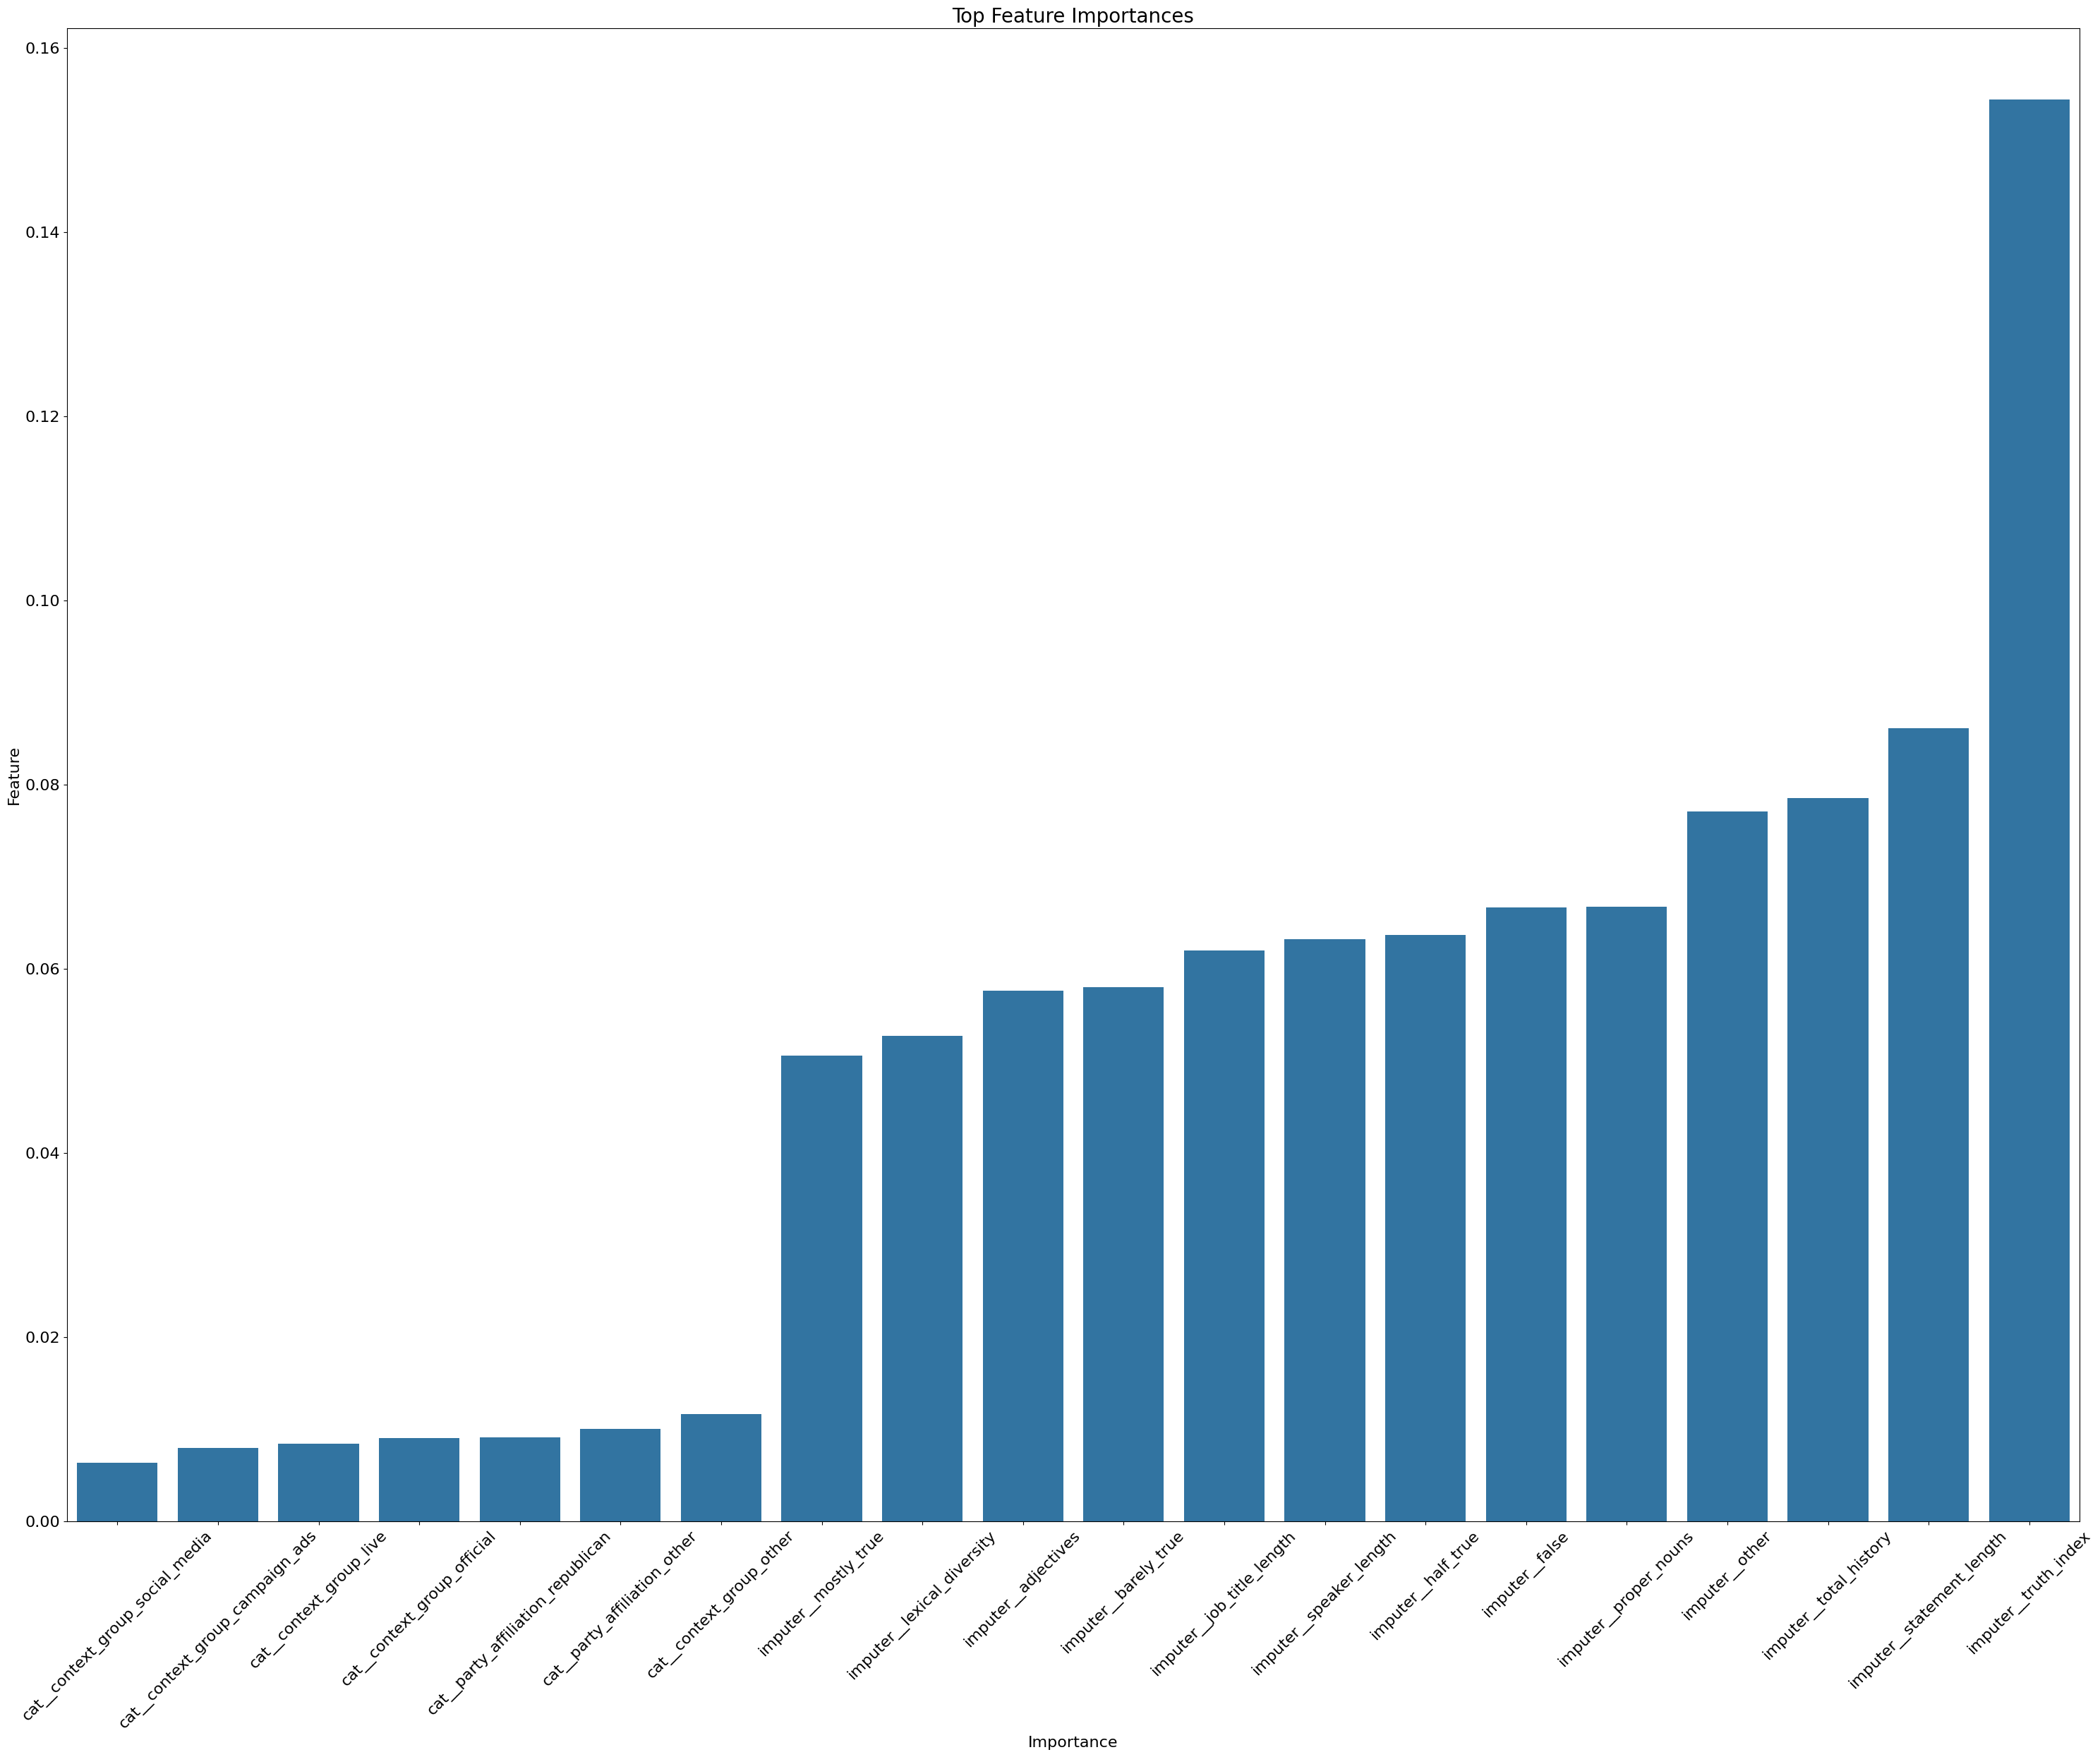

In [53]:
categorical_cols = ['context_group', 'party_affiliation']
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop = 'first'), categorical_cols),
        ('imputer', SimpleImputer(strategy='median'), numerical_cols)
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
model = grid_search(X_combined, y_combined, pipeline)[0]
calculate_metrics(y_test, model.predict(X_test), "RandomForest", model)
plot_feature_importances(model)

We see a lower result, we will try what will happen if there are no categorical columns at all

F1 Score: 0.606


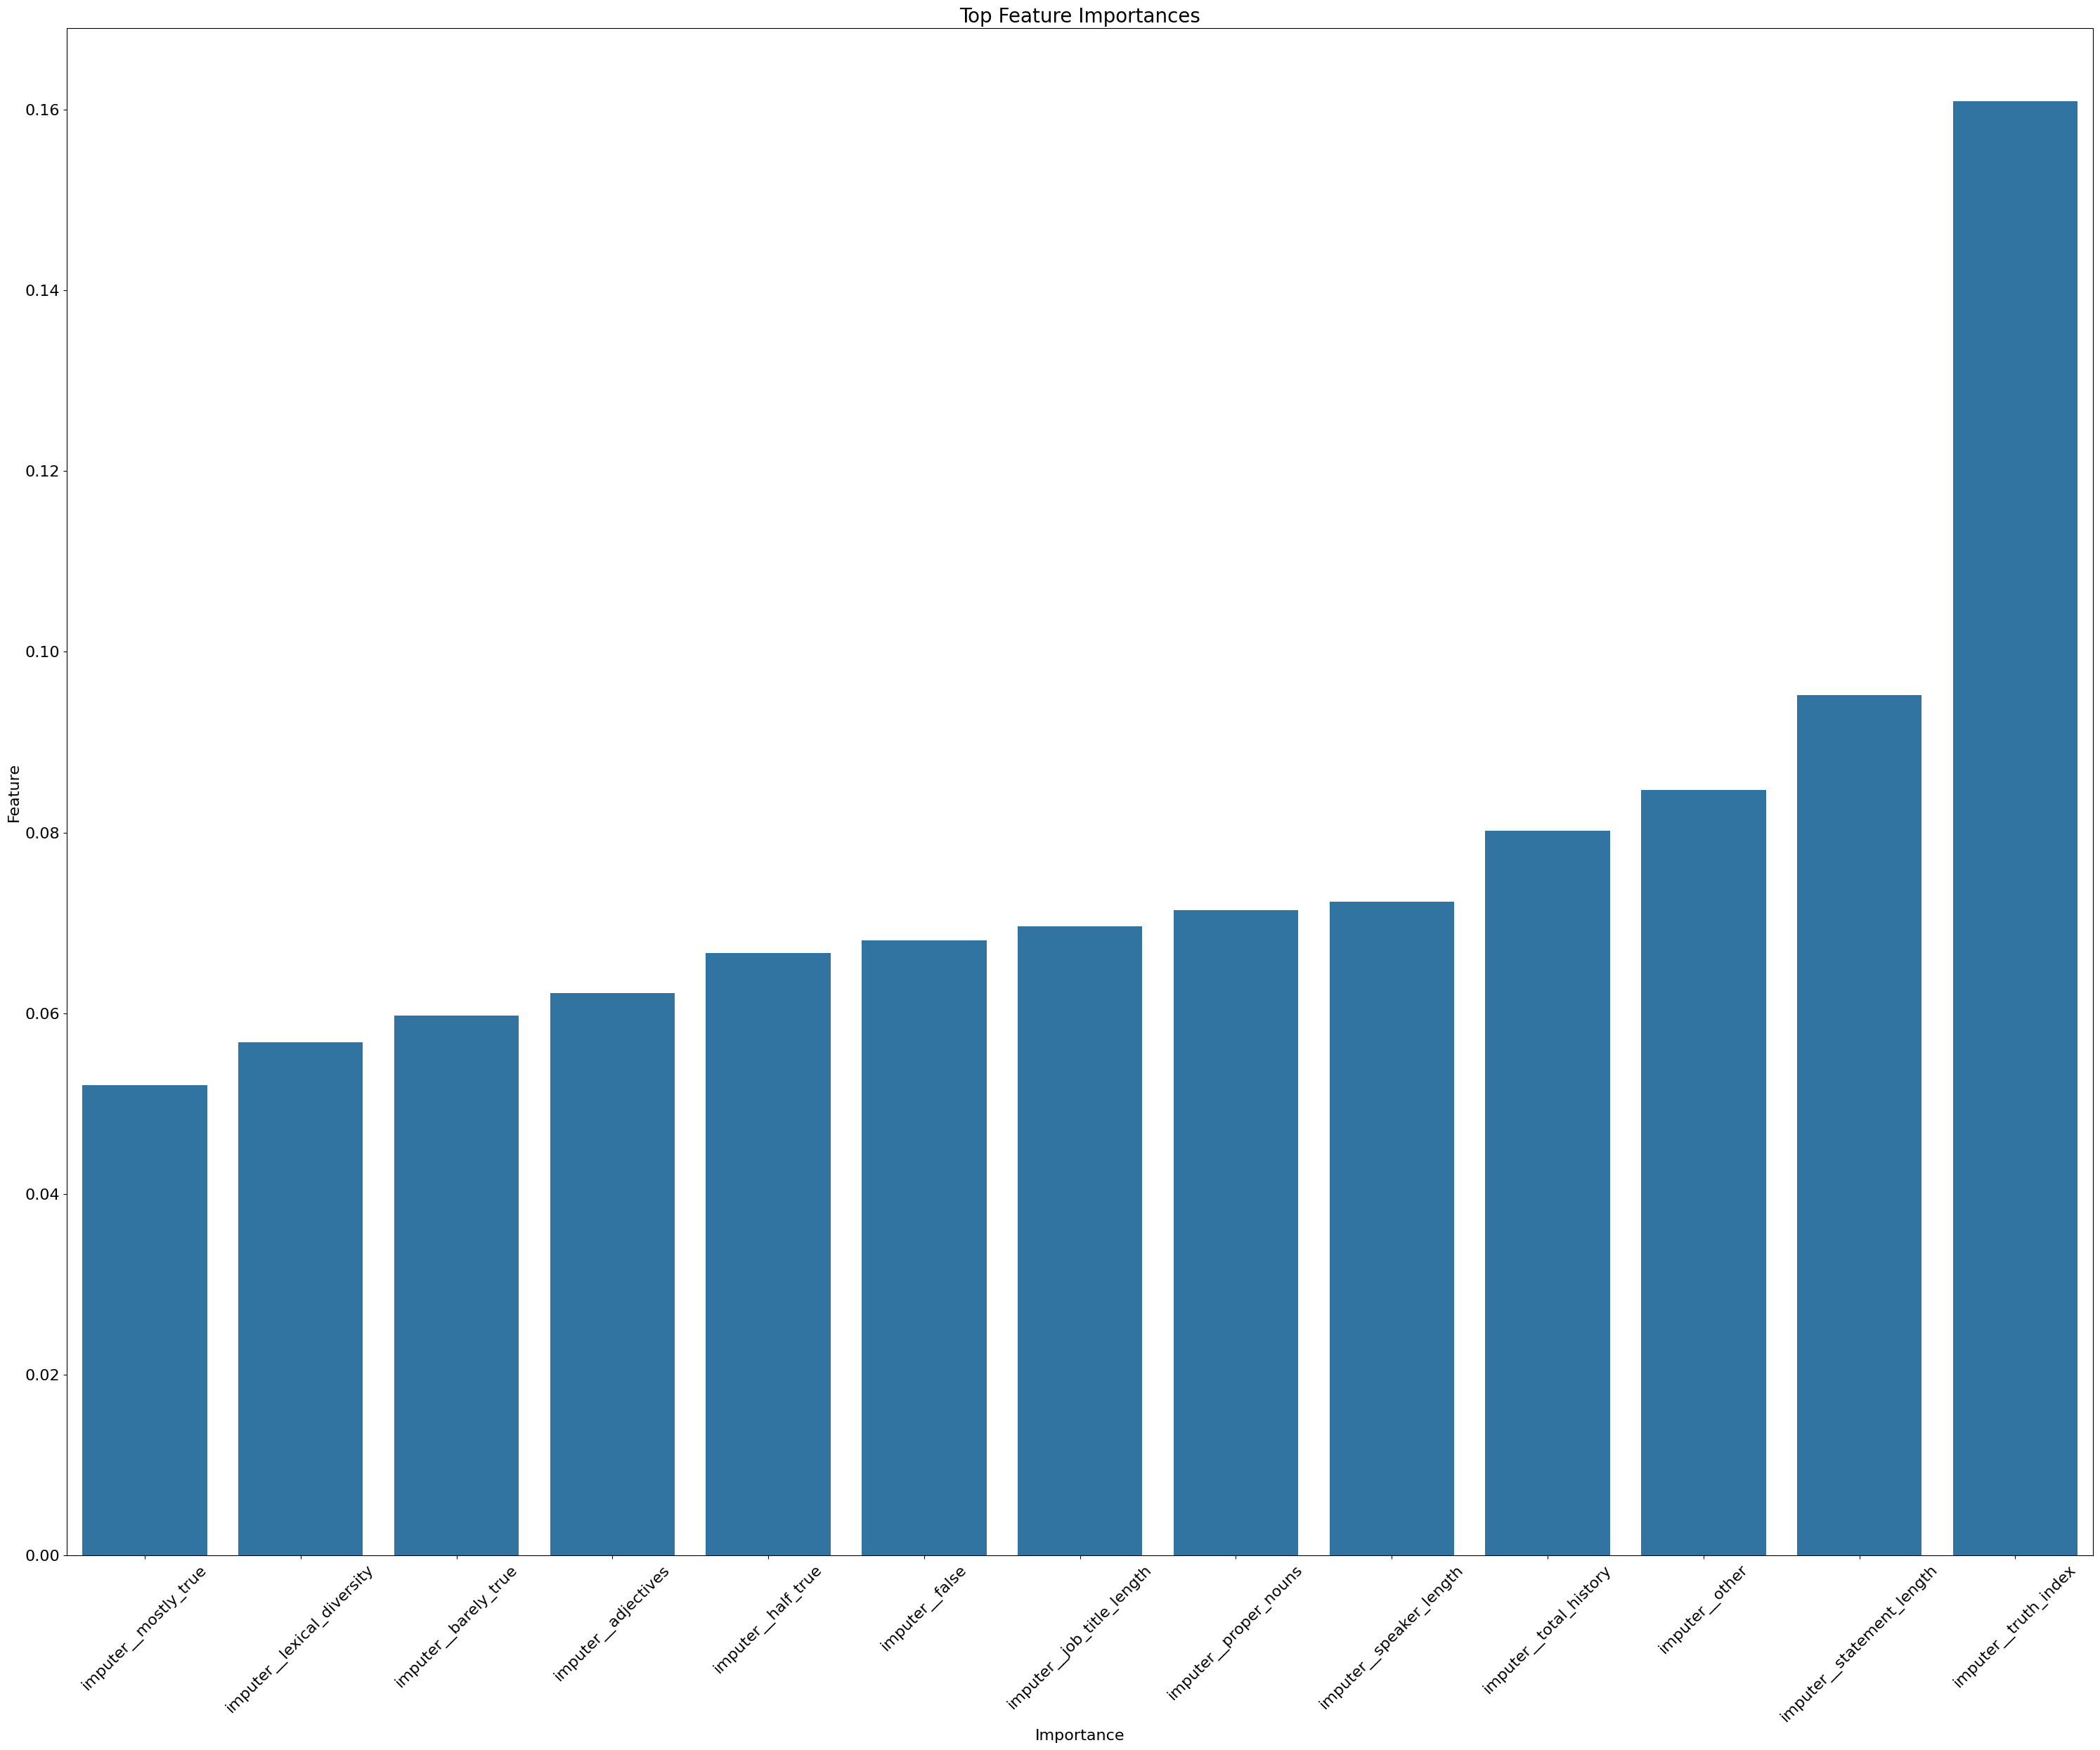

In [54]:
categorical_cols = []
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop = 'first'), categorical_cols),
        ('imputer', SimpleImputer(strategy='median'), numerical_cols)
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
model = grid_search(X_combined, y_combined, pipeline)[0]
calculate_metrics(y_test, model.predict(X_test), "RandomForest", model)
plot_feature_importances(model)

Worse results. We will now try removing mostly_true column, just because it is correlated with some other features.

F1 Score: 0.618


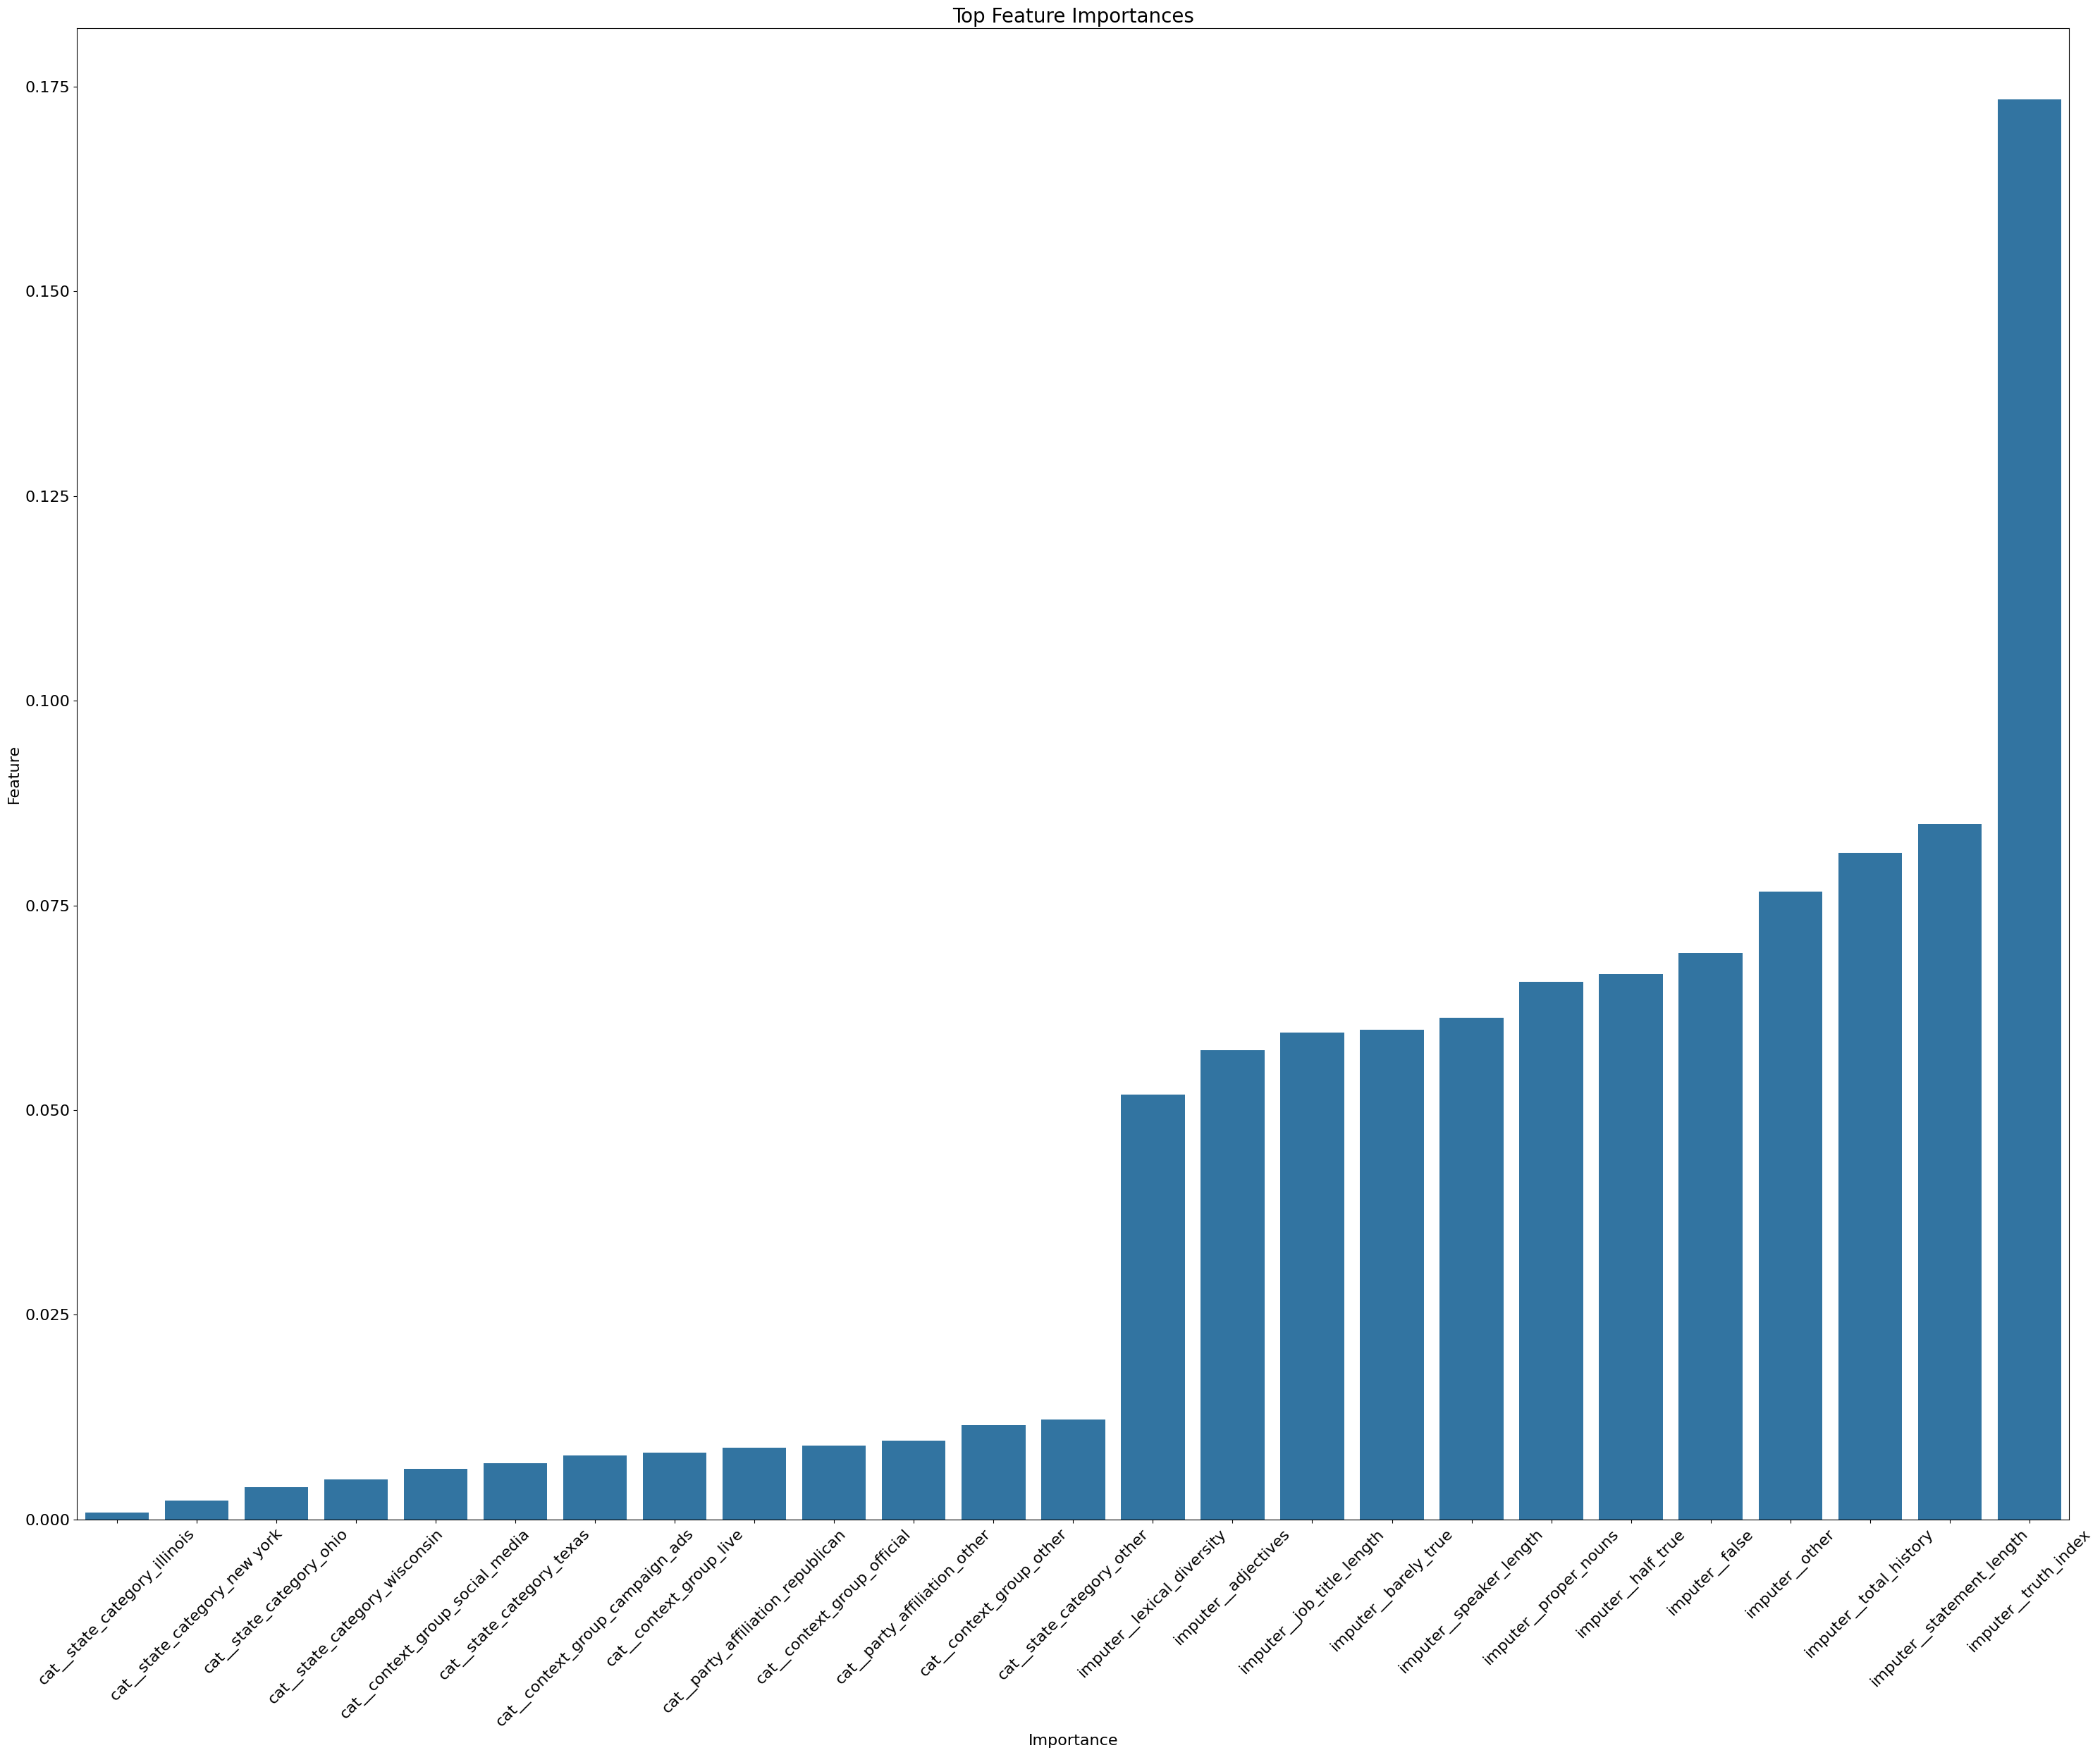

In [55]:
categorical_cols = ['party_affiliation', 'context_group', 'state_category']
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('mostly_true')
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop = 'first'), categorical_cols),
        ('imputer', SimpleImputer(strategy='median'), numerical_cols)
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
model = grid_search(X_combined, y_combined, pipeline)[0]
calculate_metrics(y_test, model.predict(X_test), "RandomForest", model)
plot_feature_importances(model)

We see a slight improvement here! We may try to remove another correlated column. Let that be barely_true

F1 Score: 0.599


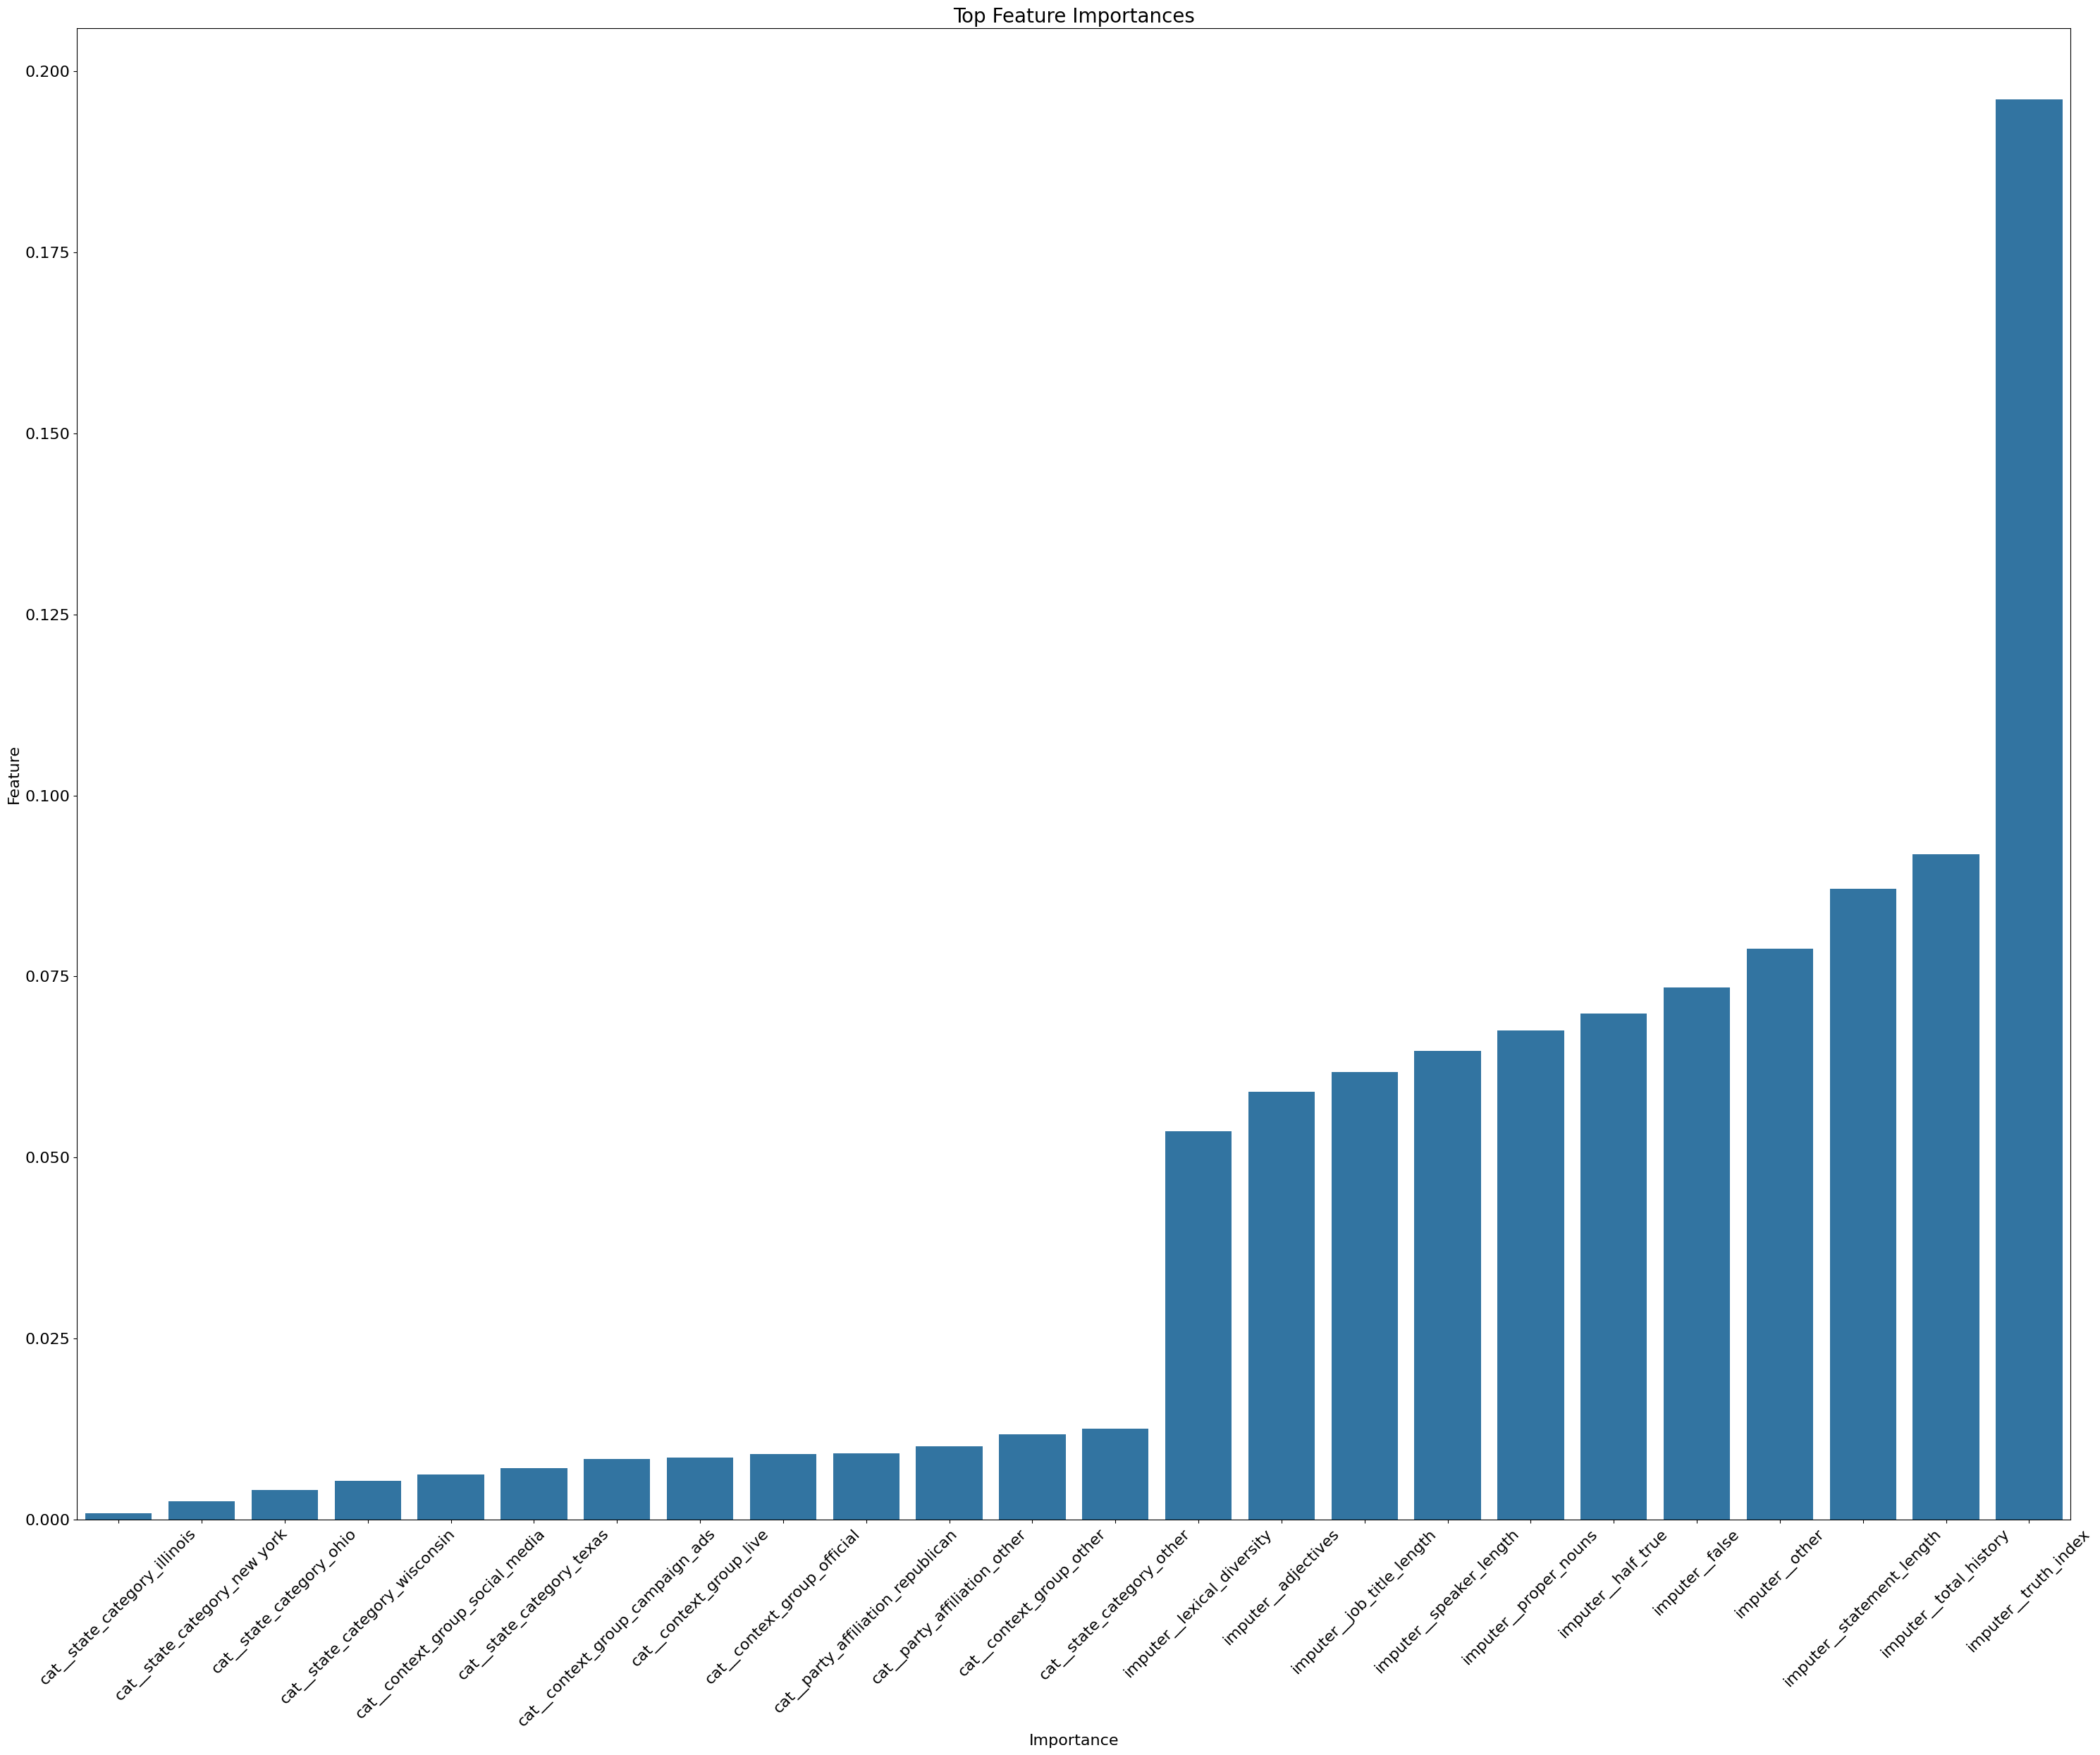

In [56]:
categorical_cols = ['party_affiliation', 'context_group', 'state_category']
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('mostly_true')
numerical_cols.remove('barely_true')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop = 'first'), categorical_cols),
        ('imputer', SimpleImputer(strategy='median'), numerical_cols)
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
model = grid_search(X_combined, y_combined, pipeline)[0]
calculate_metrics(y_test, model.predict(X_test), "RandomForest", model)
plot_feature_importances(model)

We see a lot worse results, so maybe we shouldnt remove other of the correlated columns. We should also see the statement now

F1 Score: 0.561


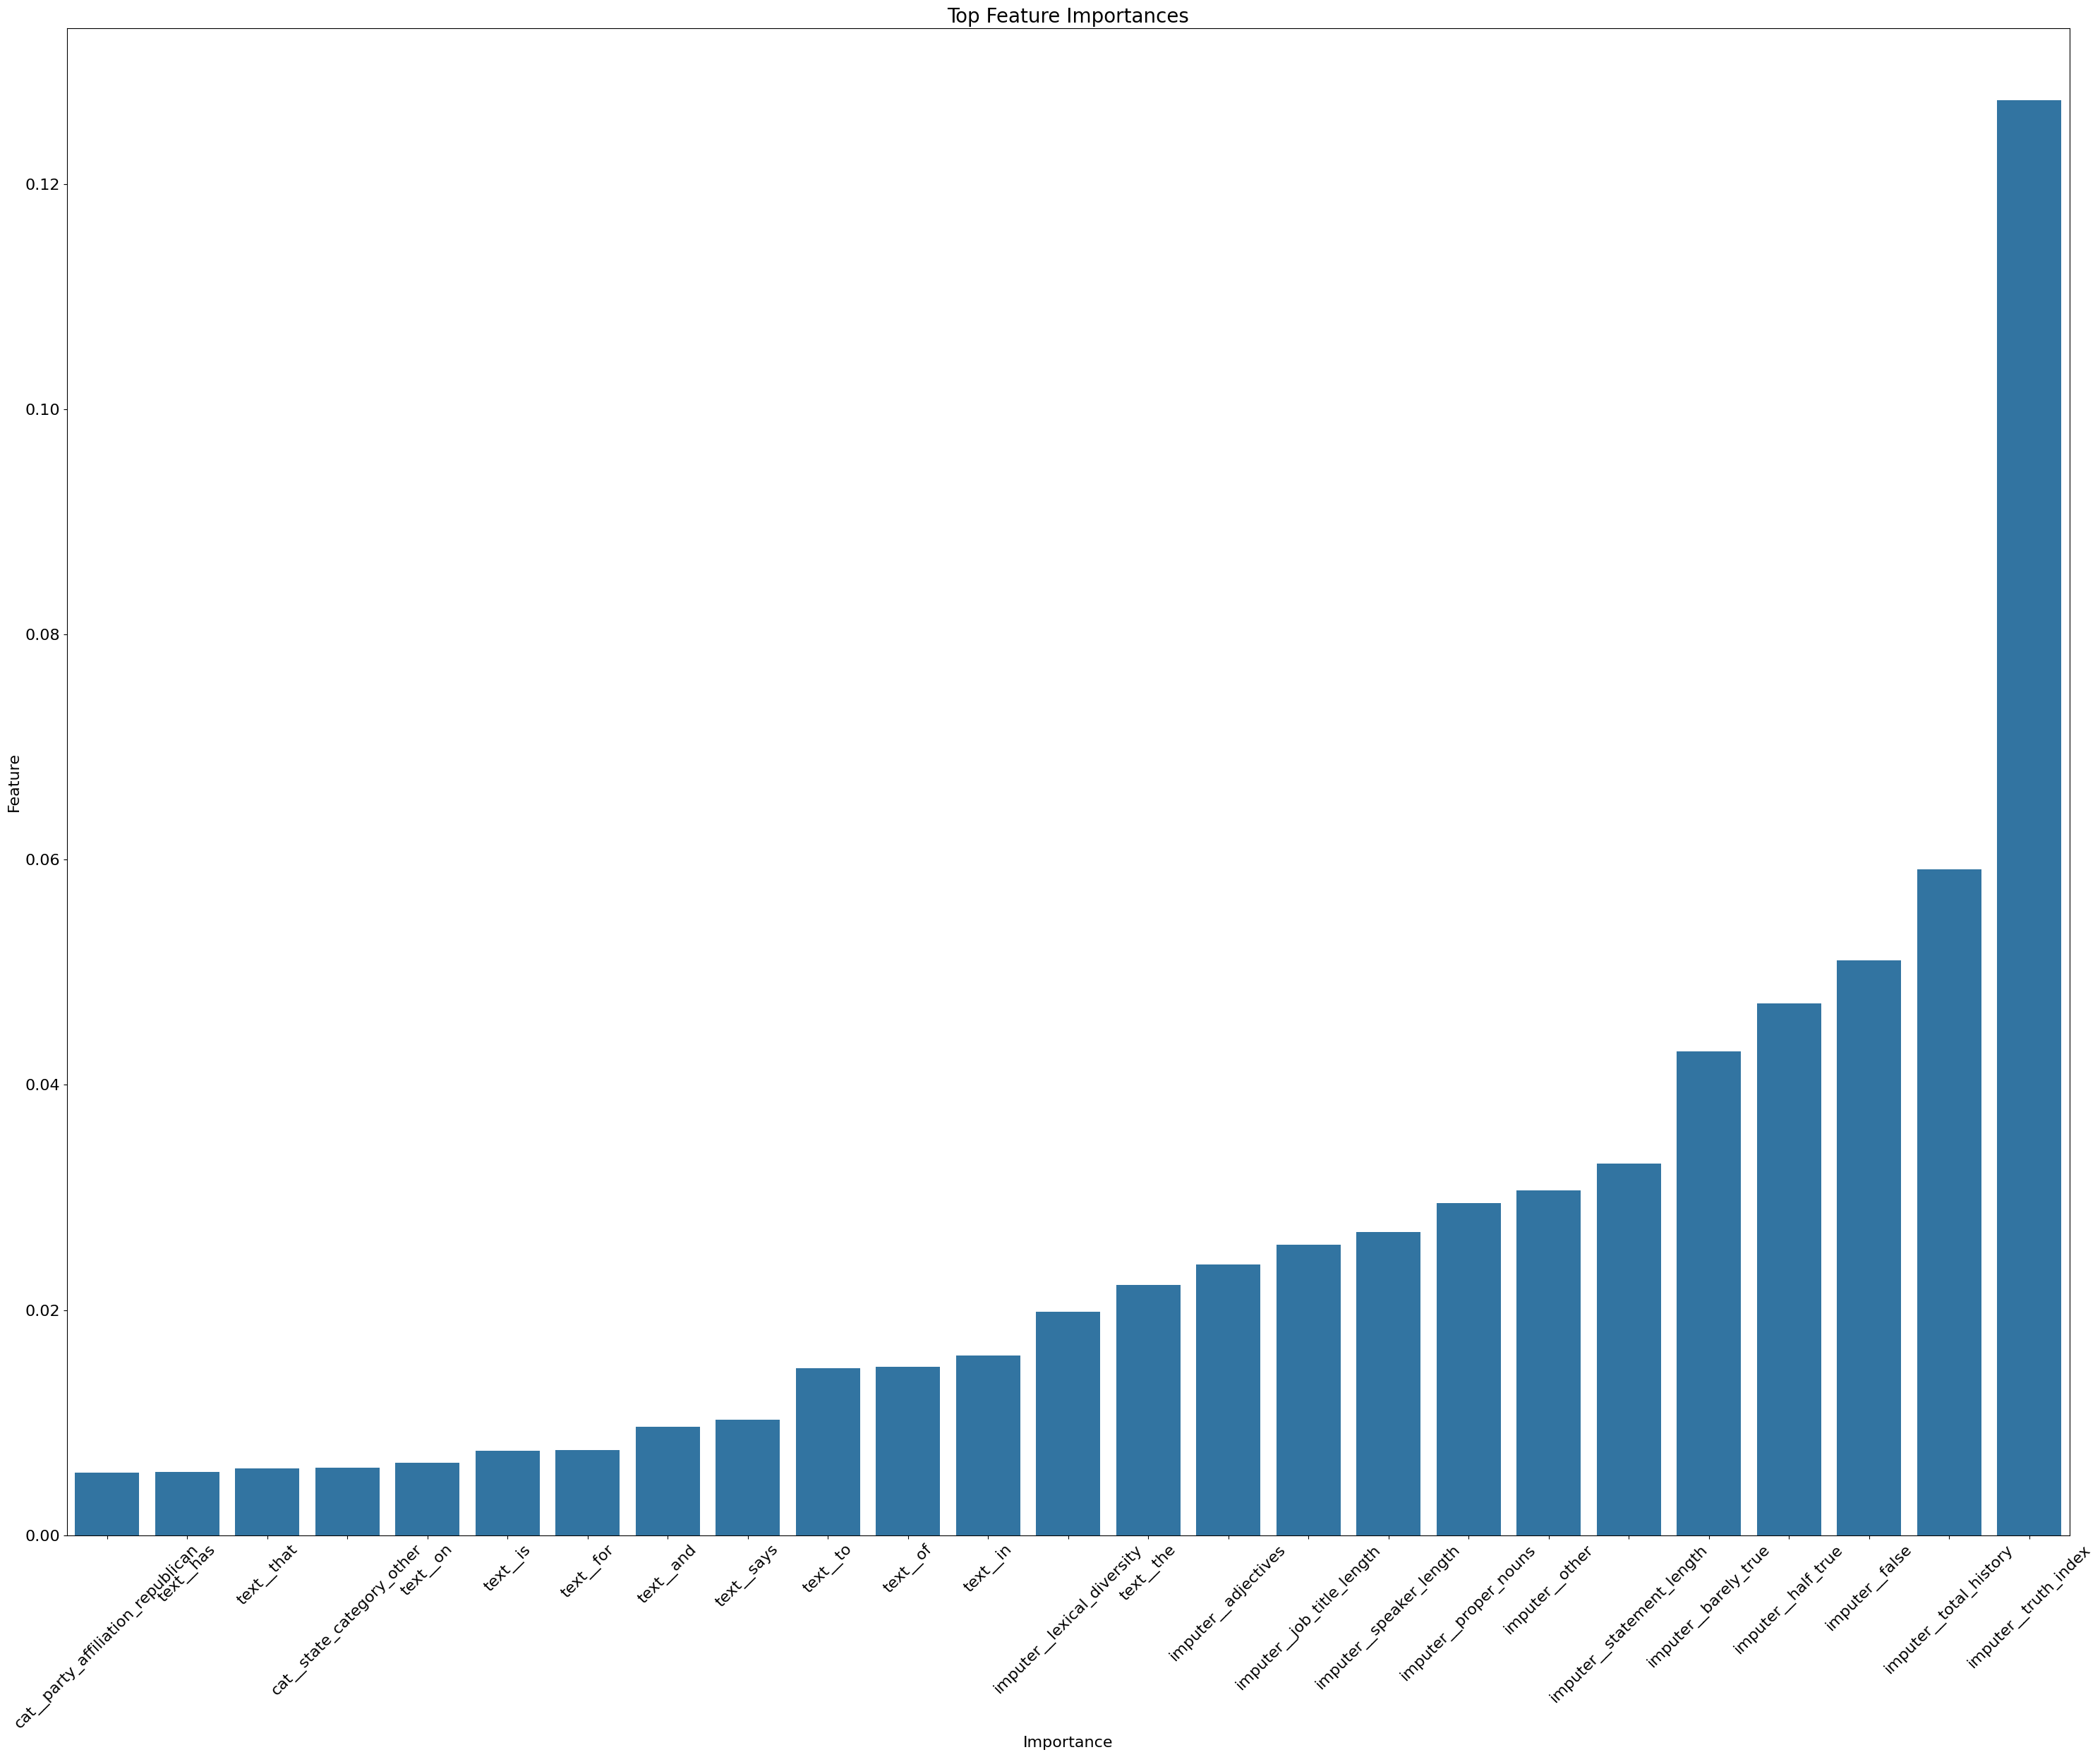

In [57]:
categorical_cols = ['party_affiliation', 'context_group', 'state_category']
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('mostly_true')

preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(), 'statement'),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop = 'first'), categorical_cols),
        ('imputer', SimpleImputer(strategy='median'), numerical_cols)
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
model = grid_search(X_combined, y_combined, pipeline)[0]
calculate_metrics(y_test, model.predict(X_test), "RandomForest", model)
plot_feature_importances(model)

As it long too much of a time we will analyze the statemenet column alone

F1 Score: 0.238


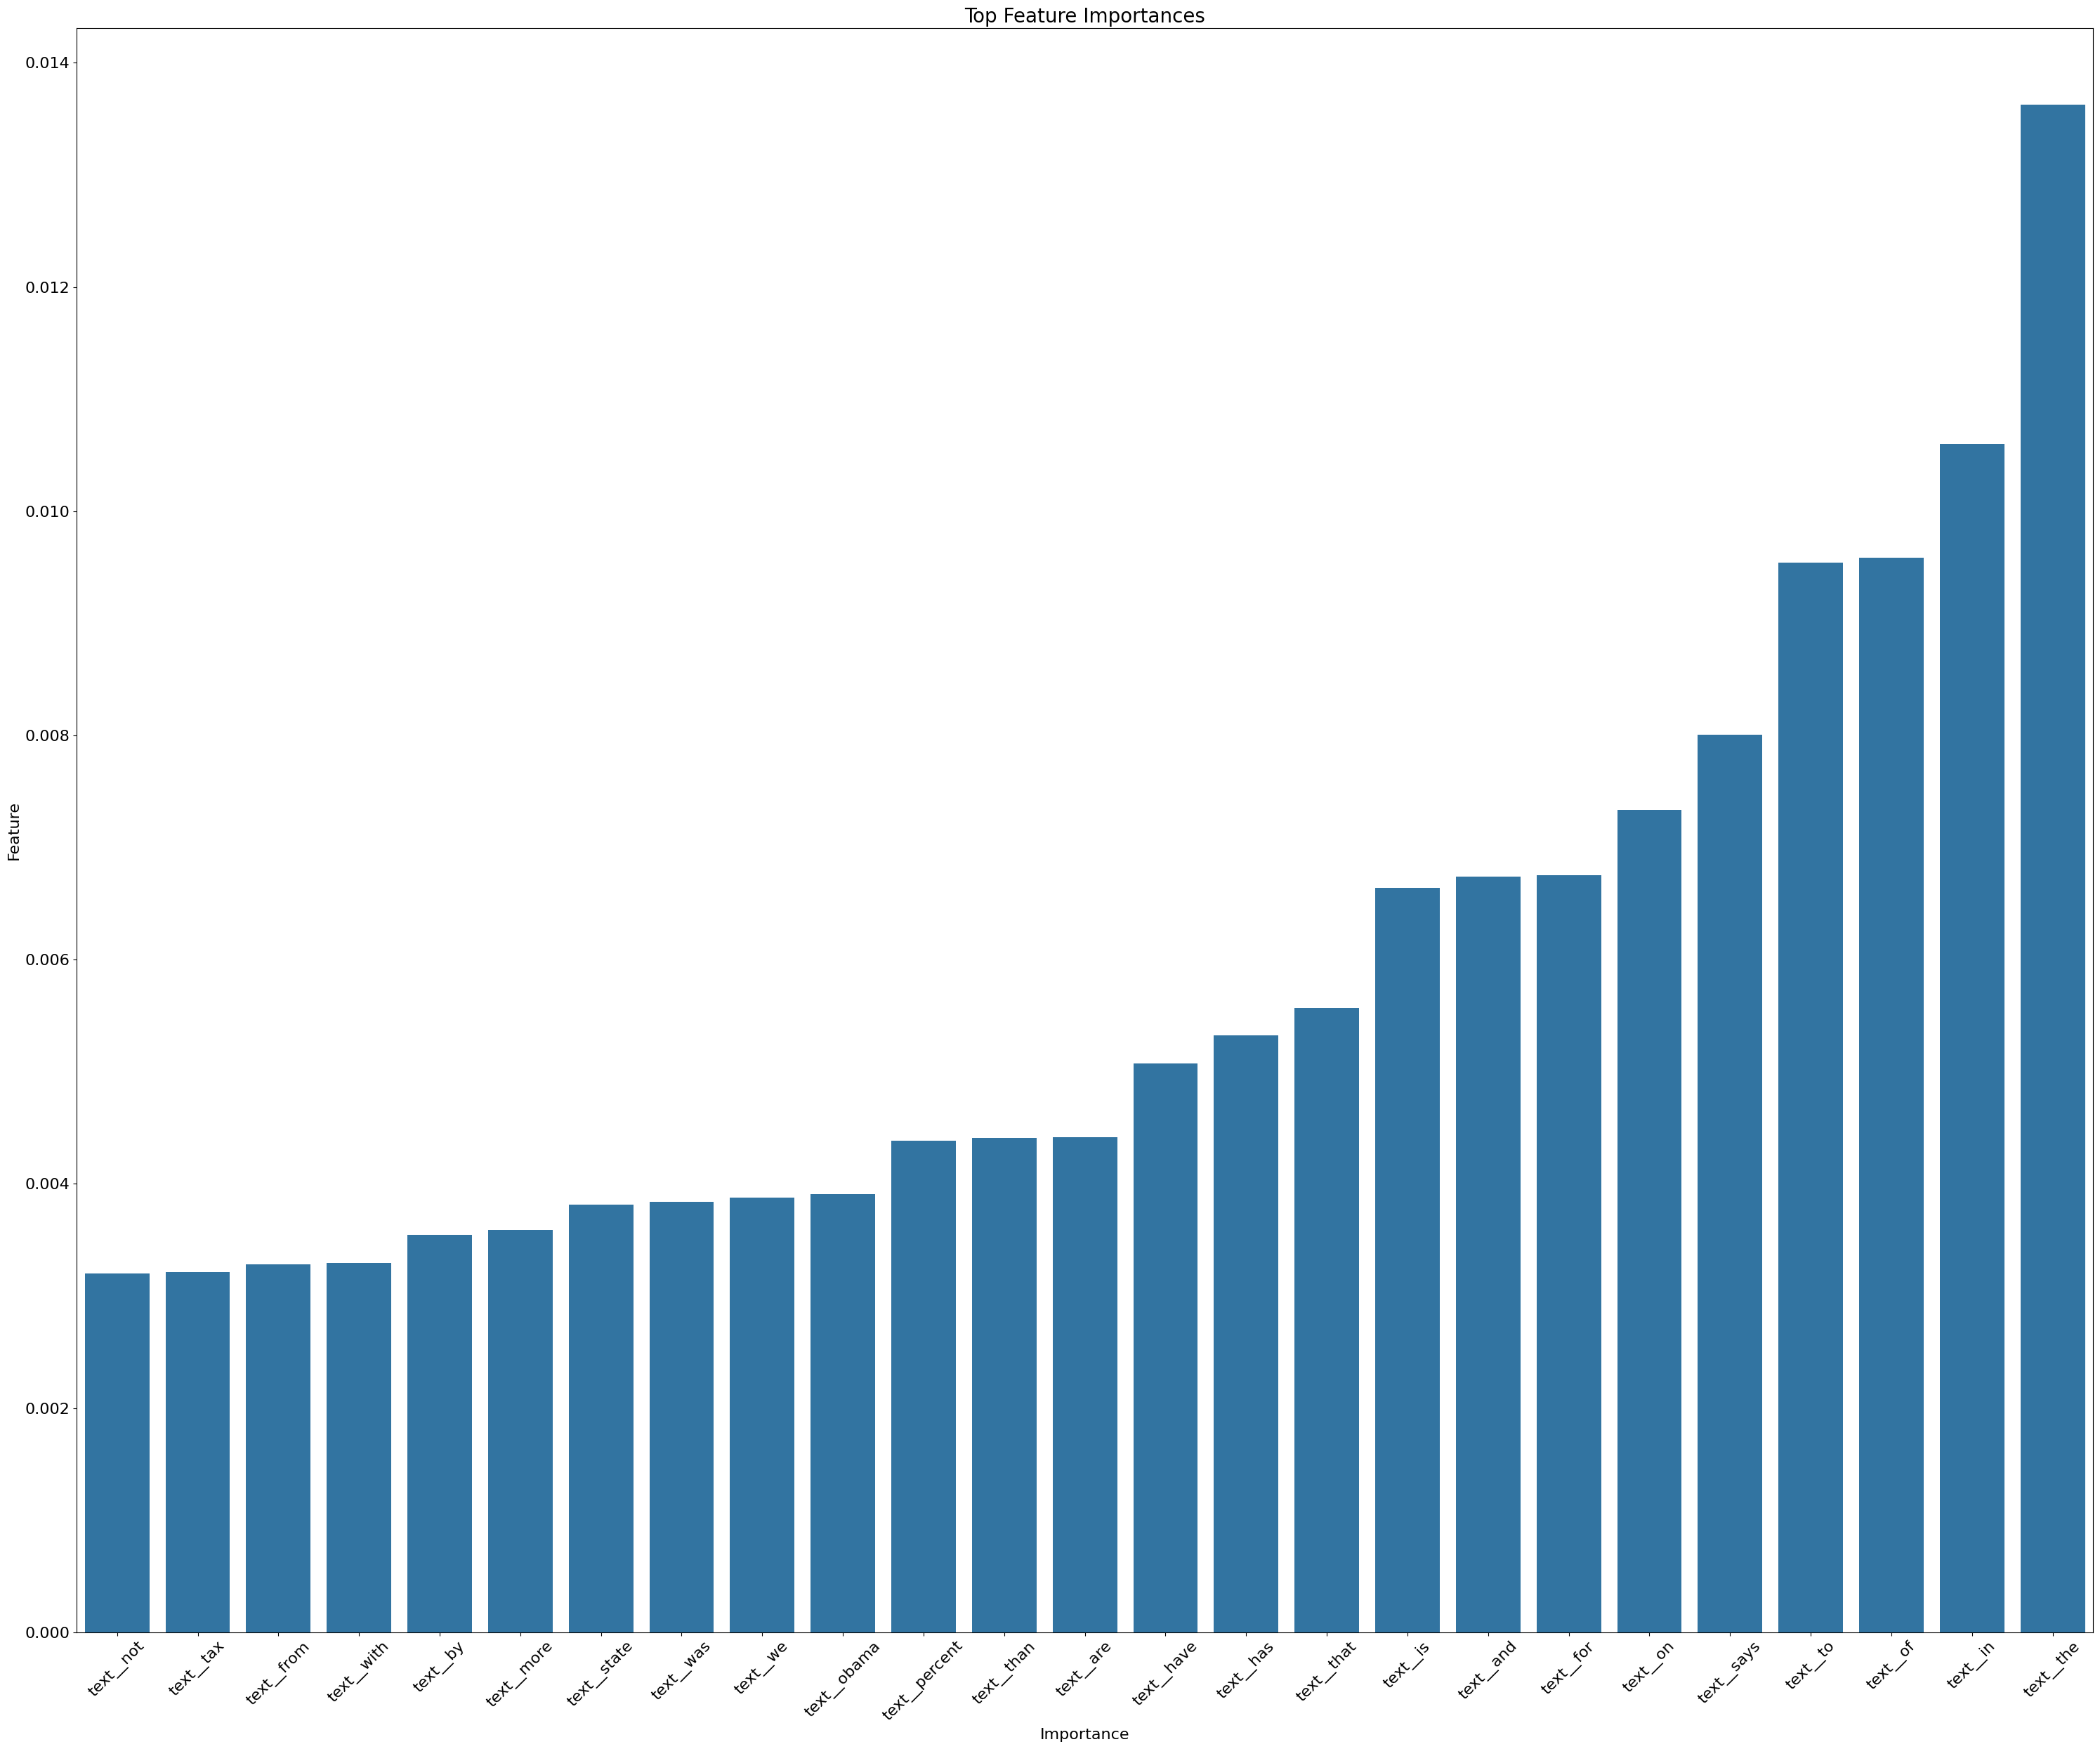

In [58]:
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(), 'statement'),
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
model = grid_search(X_combined, y_combined, pipeline)[0]
calculate_metrics(y_test, model.predict(X_test), "RandomForest", model)
plot_feature_importances(model)

Not a very good score, but expected given our previous models. We will try with removing stopwords now

F1 Score: 0.249


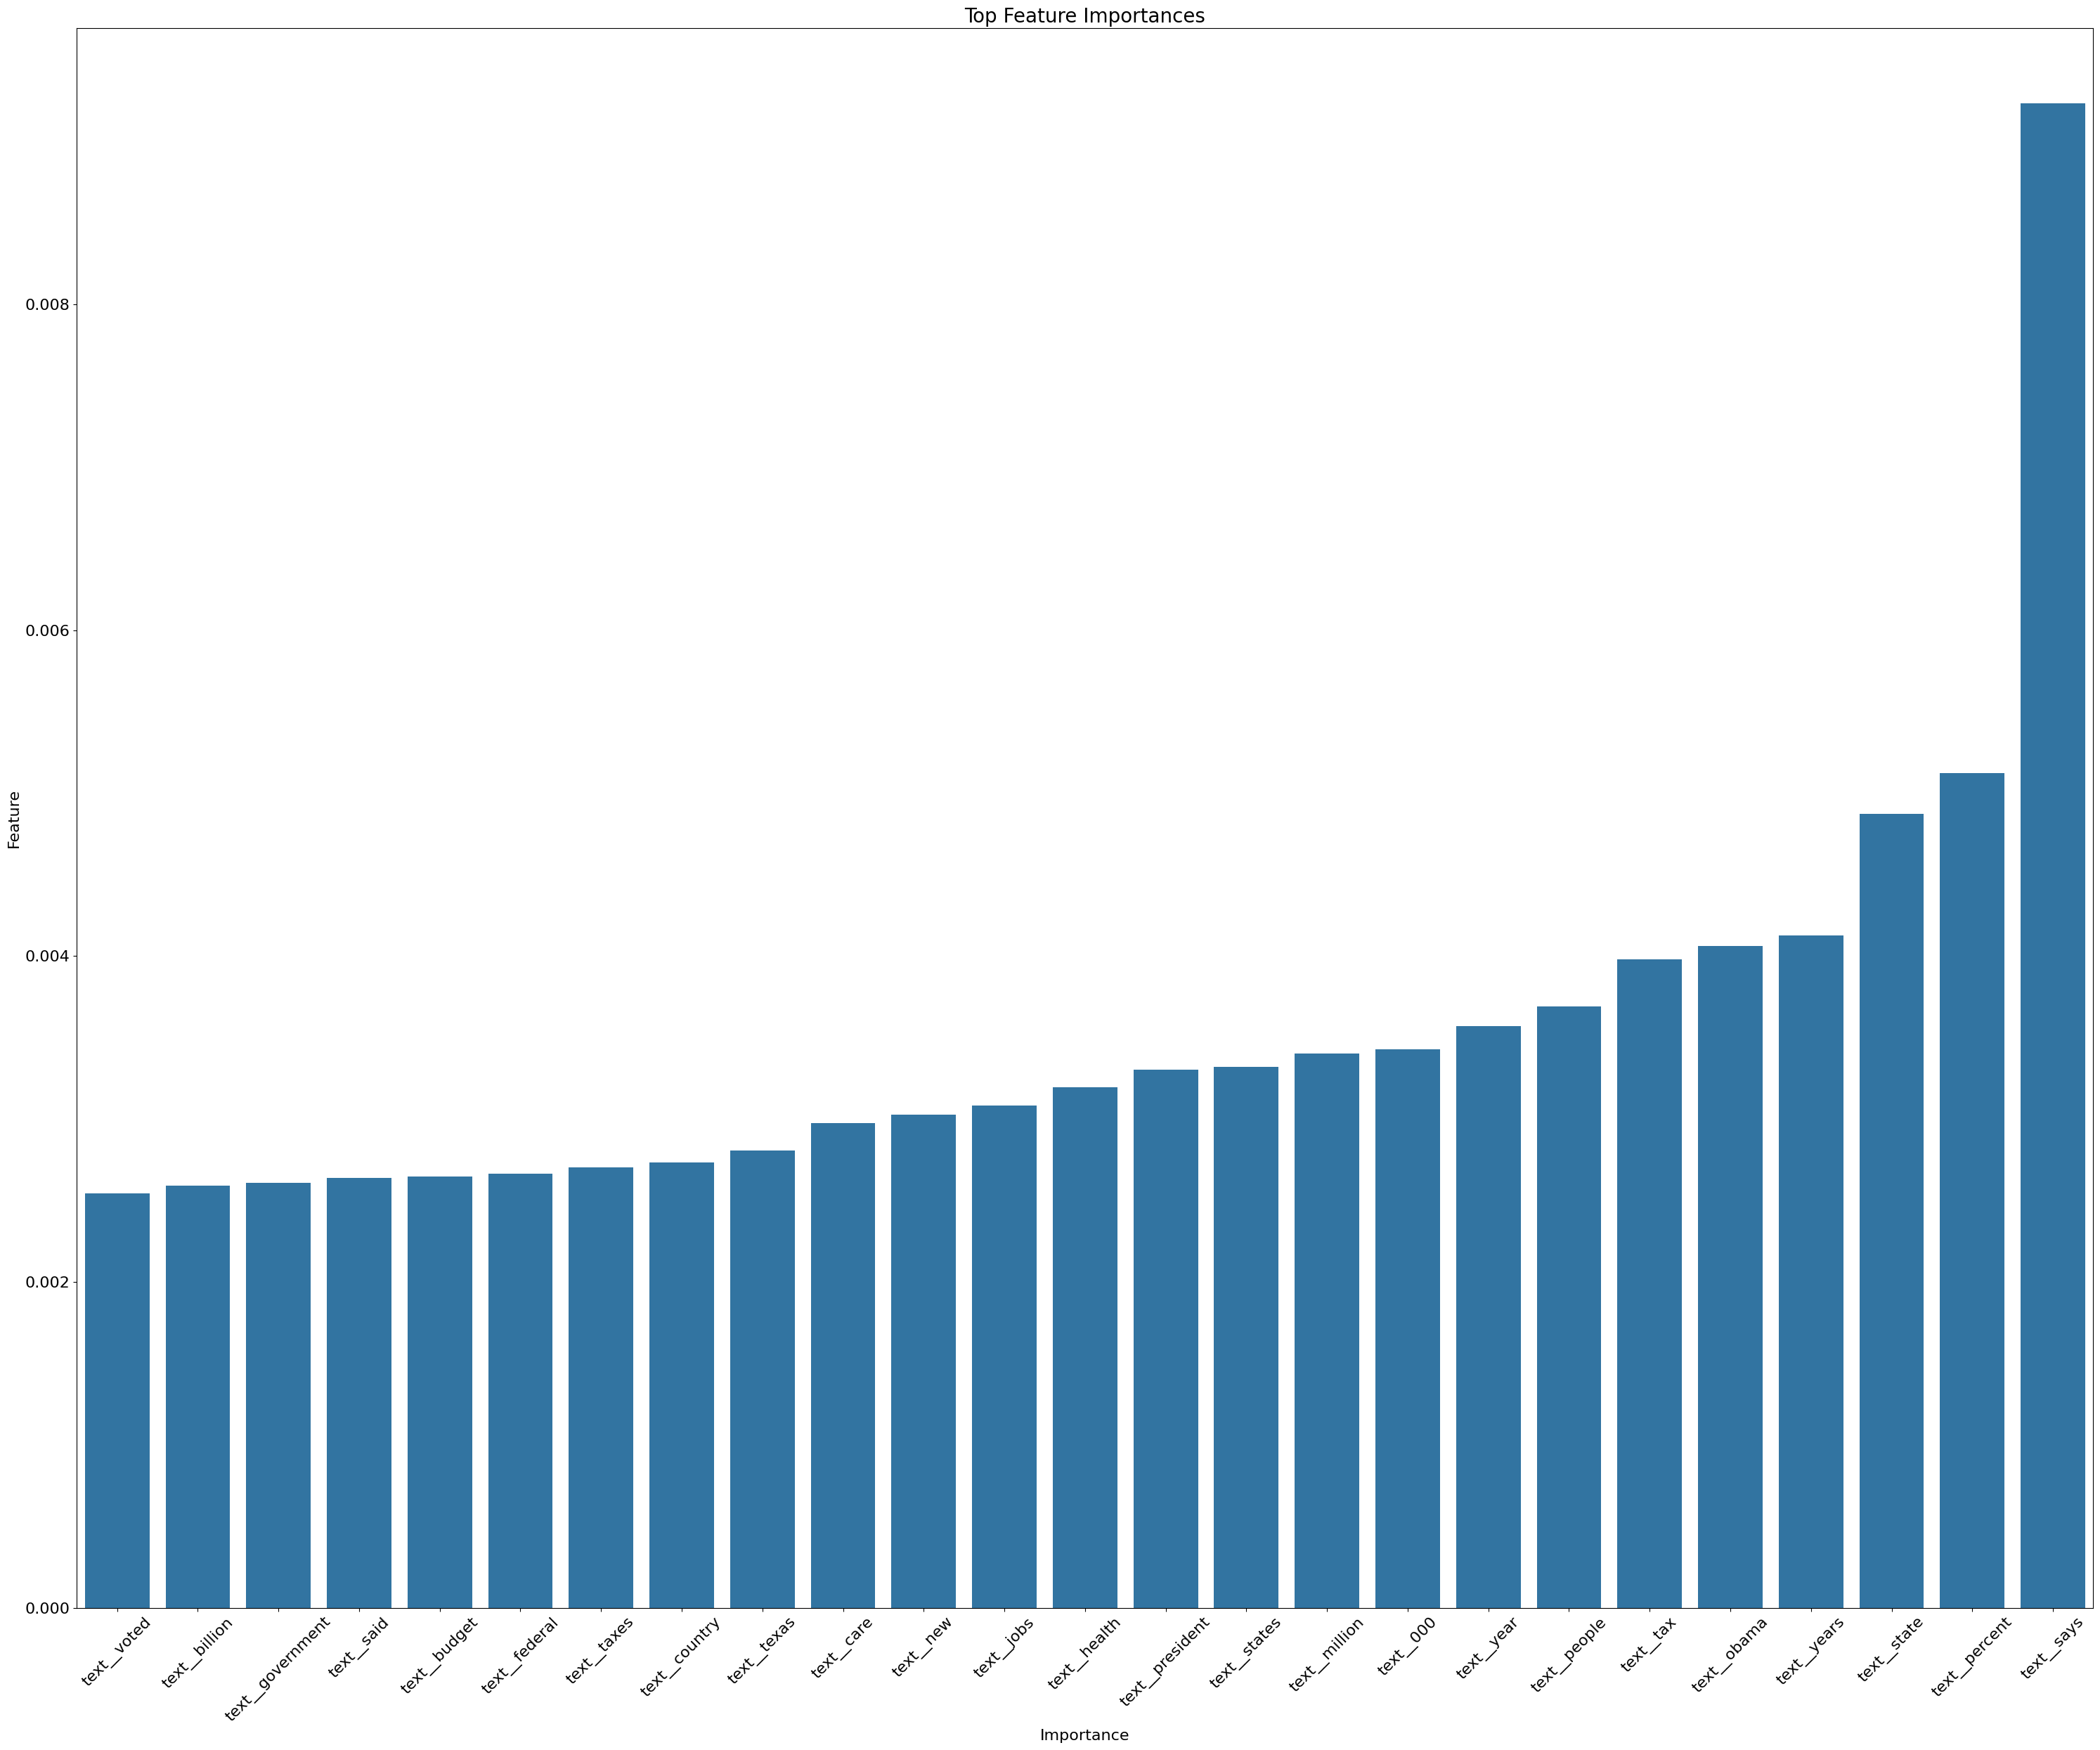

In [59]:
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(stop_words='english'), 'statement'),
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
model = grid_search(X_combined, y_combined, pipeline)[0]
calculate_metrics(y_test, model.predict(X_test), "RandomForest", model)
plot_feature_importances(model)

Now we get definetely better results. Let us try them with the best model obtained so far

In [61]:
print(report)

[{'model': 'Baseline(predicting the most common class)', 'n_estimators': None, 'max_features': None, 'accuracy': 0.20537878195606285, 'precision': 0.04218044407775601, 'recall': 0.20537878195606285, 'f1': 0.06998703595778663}, {'model': 'RandomForest', 'n_estimators': 400, 'max_features': None, 'criterion': 'gini', 'accuracy': 0.6203630623520127, 'precision': 0.6285333406866465, 'recall': 0.6203630623520127, 'f1': 0.6171469995545255}, {'model': 'RandomForest', 'n_estimators': 300, 'max_features': None, 'criterion': 'gini', 'accuracy': 0.6148382004735596, 'precision': 0.6217893339620761, 'recall': 0.6148382004735596, 'f1': 0.611240386781649}, {'model': 'RandomForest', 'n_estimators': 200, 'max_features': None, 'criterion': 'gini', 'accuracy': 0.6085240726124704, 'precision': 0.6185796622907792, 'recall': 0.6085240726124704, 'f1': 0.6055876045111546}, {'model': 'RandomForest', 'n_estimators': 200, 'max_features': None, 'criterion': 'gini', 'accuracy': 0.6219415943172849, 'precision': 0.6

F1 Score: 0.603


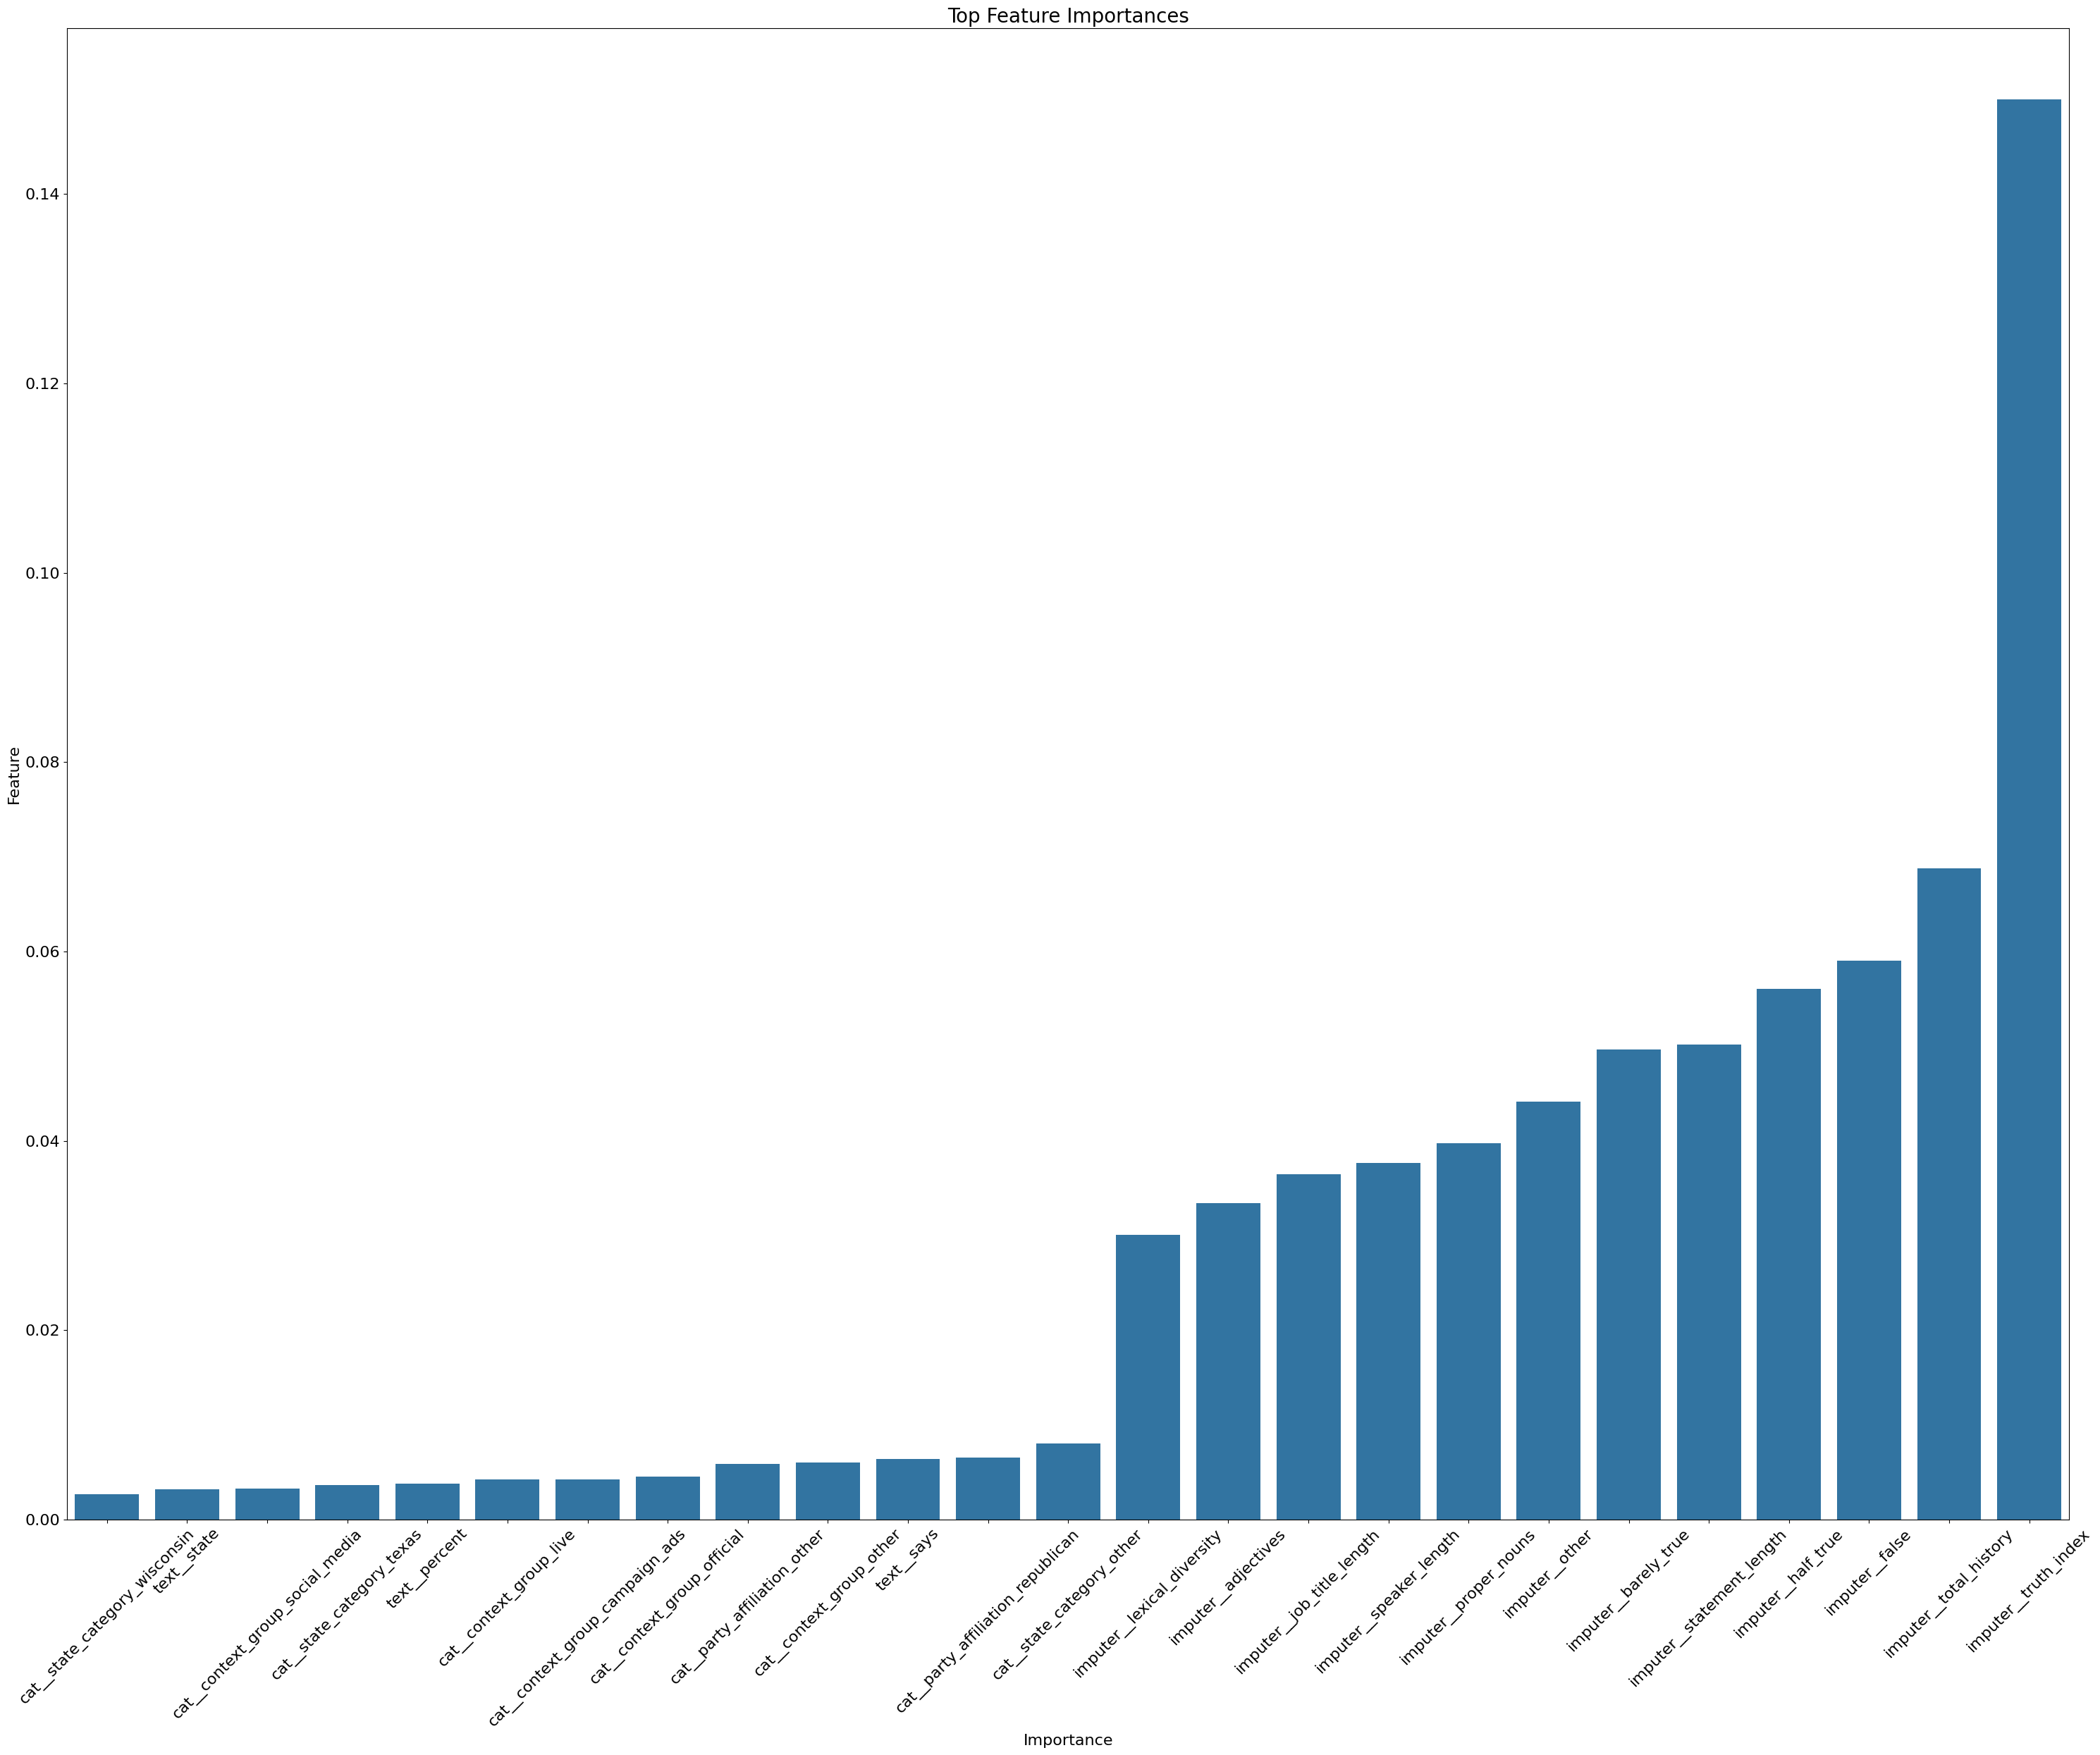

In [62]:
best_model = RandomForestClassifier(random_state=42, n_estimators=200, max_features=None, n_jobs=-1)
categorical_cols = ['party_affiliation', 'context_group', 'state_category']
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('mostly_true')
preprocessor = ColumnTransformer(
    transformers=[
        ('text', CountVectorizer(stop_words='english'), 'statement'),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop = 'first'), categorical_cols),
        ('imputer', SimpleImputer(strategy='median'), numerical_cols)
    ],
    remainder='drop'
)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', best_model)
])
model = pipeline.fit(X_combined, y_combined)
calculate_metrics(y_test, model.predict(X_test), "RandomForest", model)
plot_feature_importances(model)

Not very good result also, let us try the vectorization method from the best Decision Tree model we built

F1 Score: 0.586


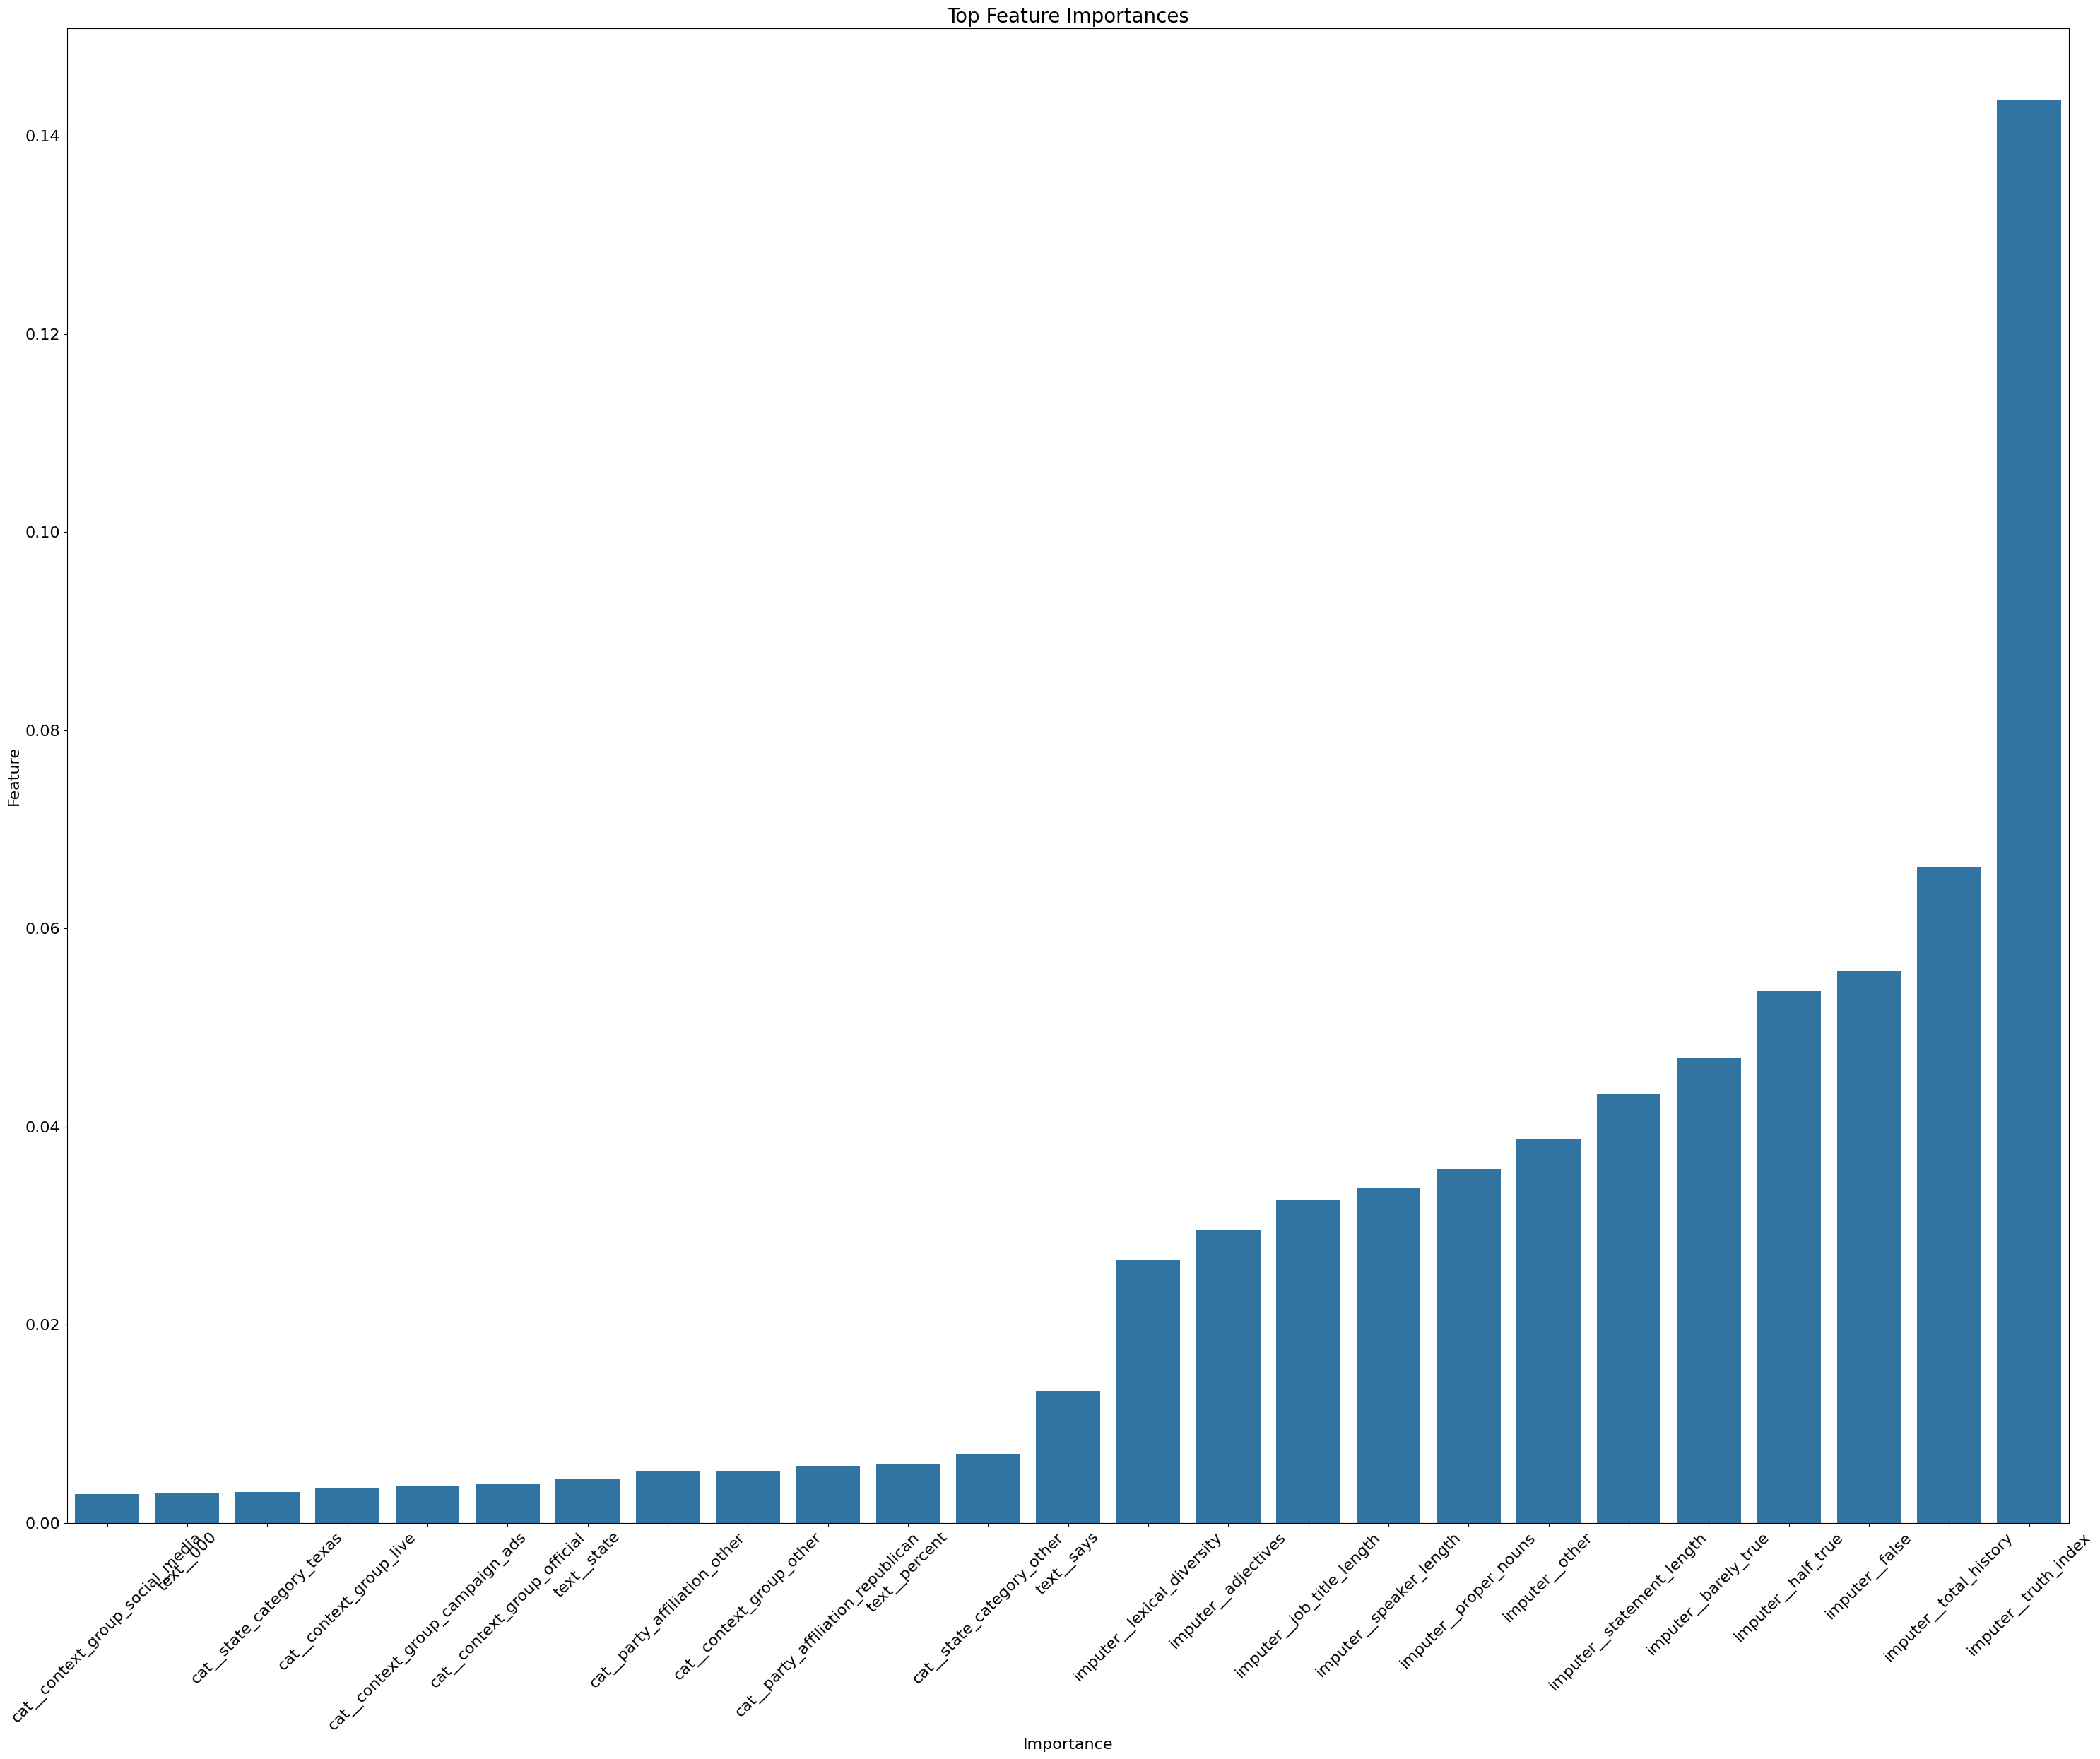

In [63]:
best_model = RandomForestClassifier(random_state=42, n_estimators=200, max_features=None, n_jobs=-1)
categorical_cols = ['party_affiliation', 'context_group', 'state_category']
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('mostly_true')
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(stop_words='english', ngram_range=(1, 2)), 'statement'),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop = 'first'), categorical_cols),
        ('imputer', SimpleImputer(strategy='median'), numerical_cols)
    ],
    remainder='drop'
)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', best_model)
])
model = pipeline.fit(X_combined, y_combined)
calculate_metrics(y_test, model.predict(X_test), "RandomForest", model)
plot_feature_importances(model)

We got worse results, Let us try limiting the number of words

F1 Score: 0.604


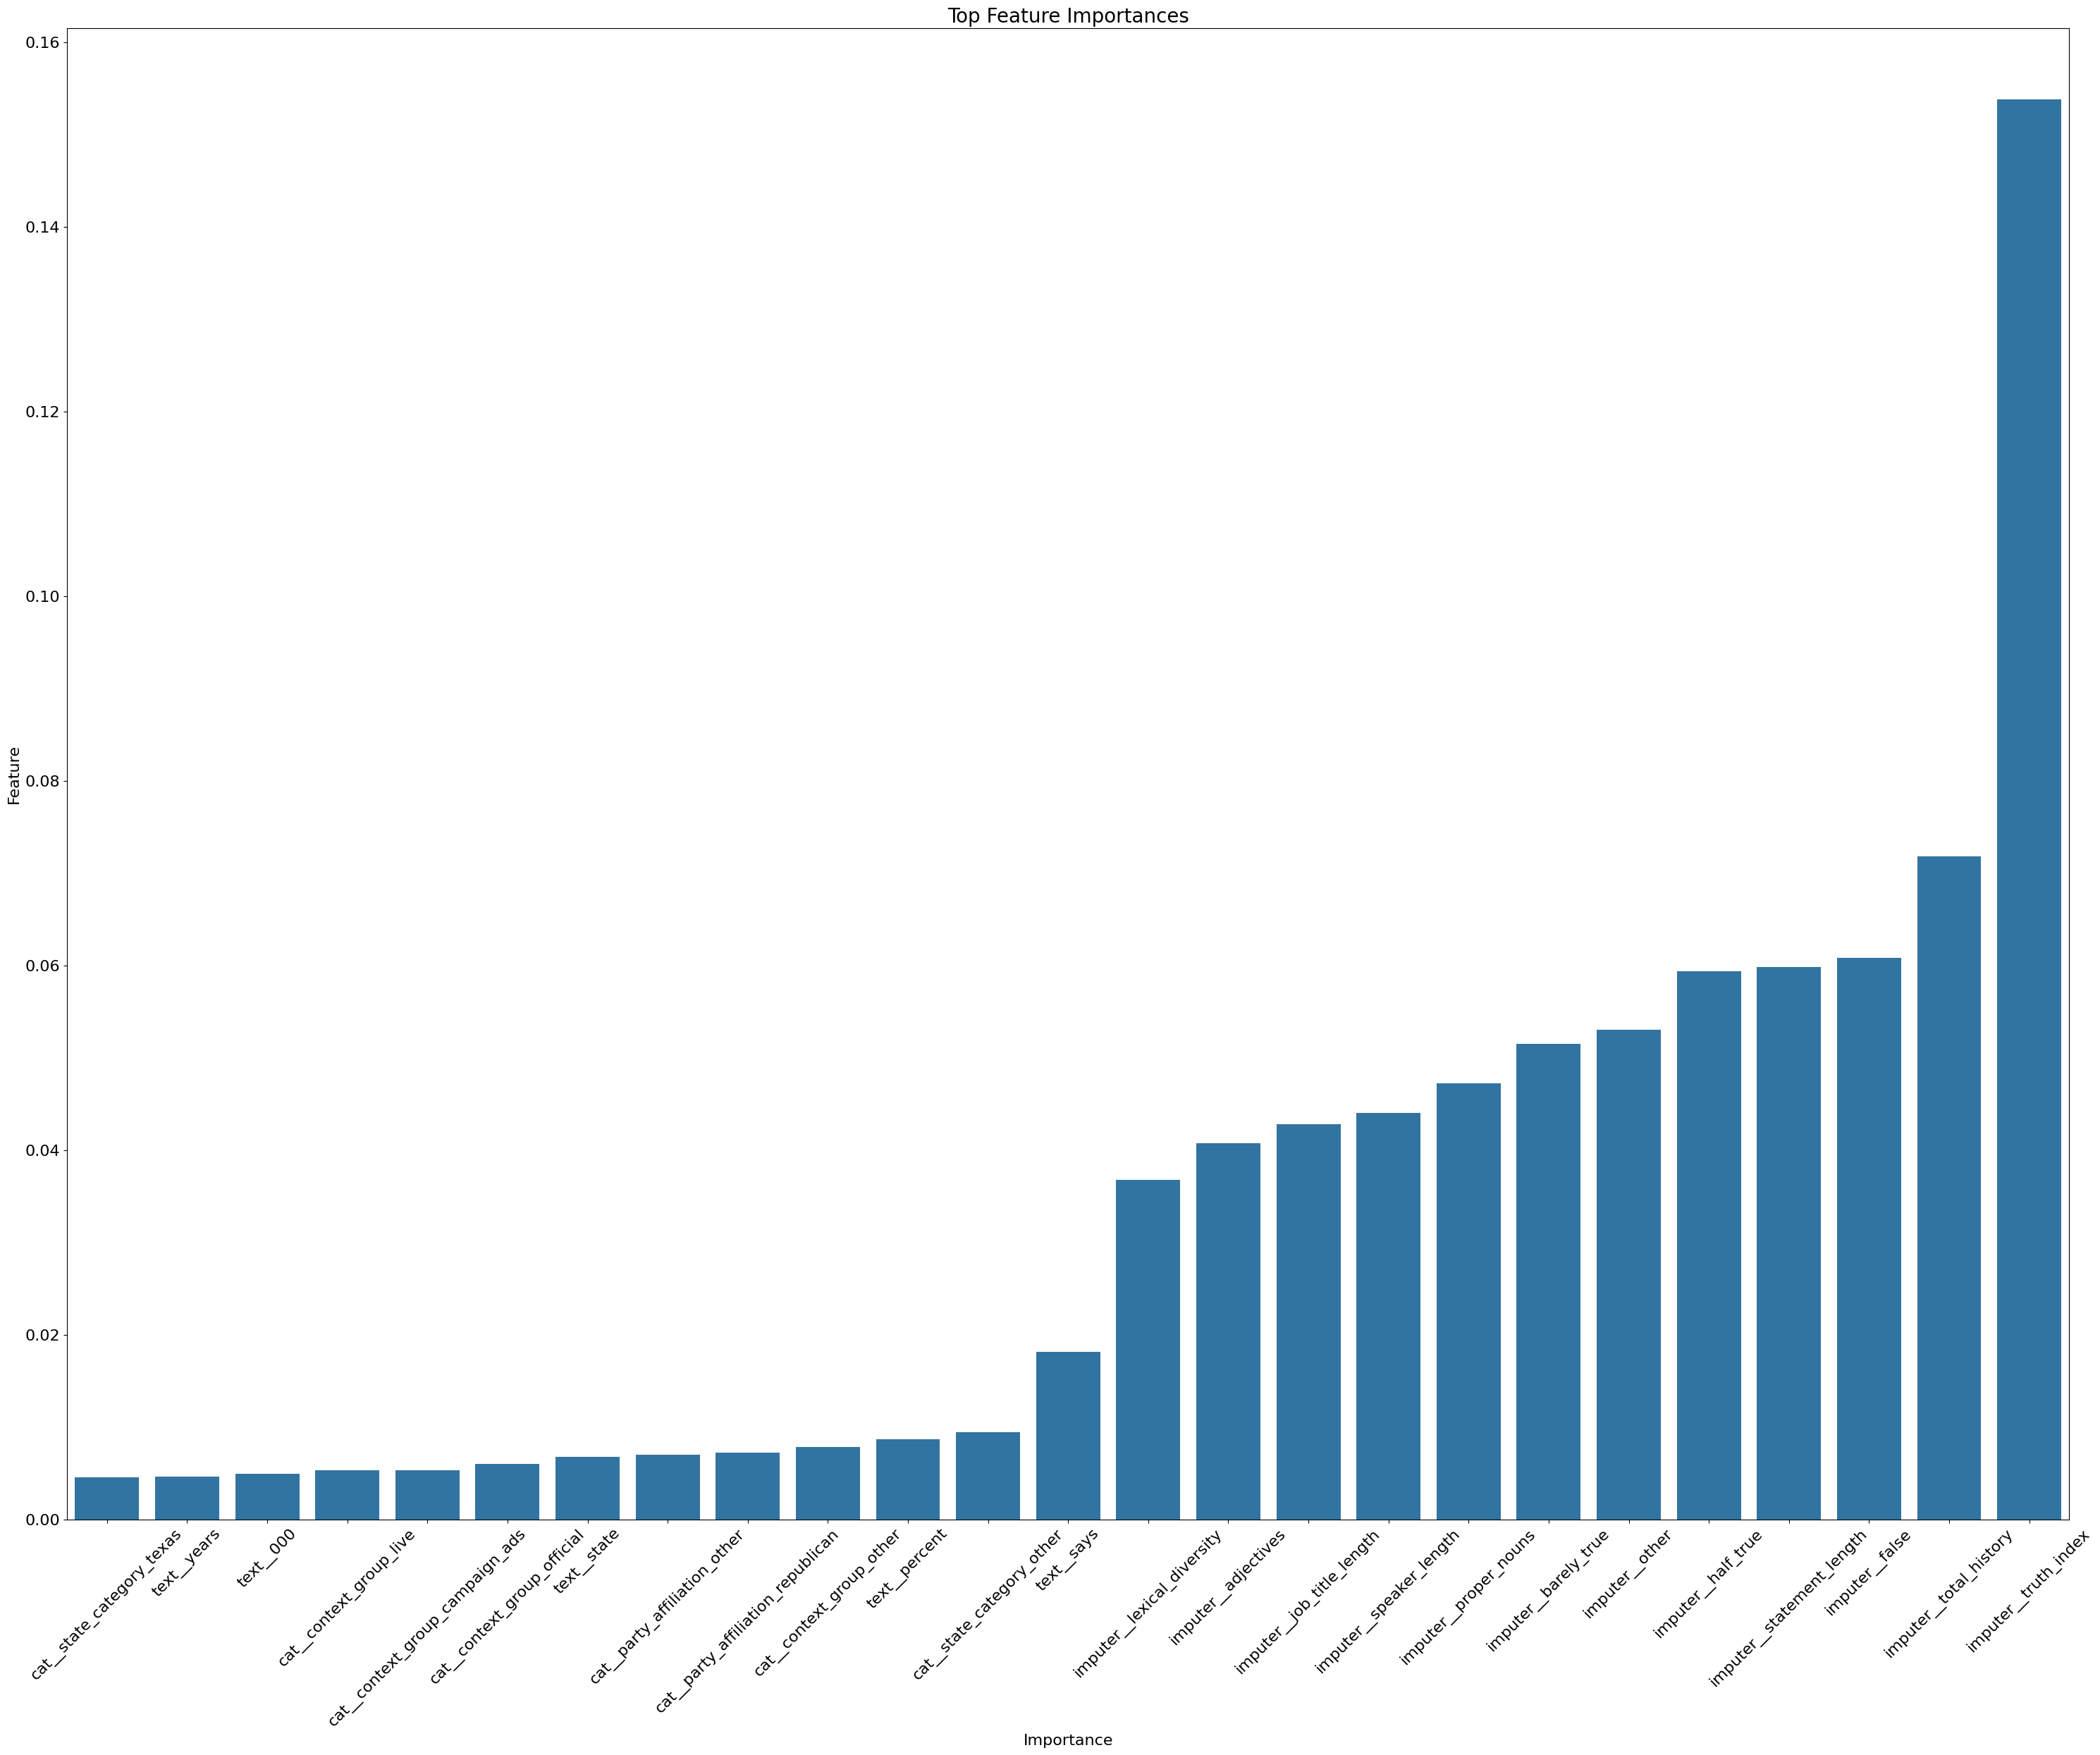

In [64]:
best_model = RandomForestClassifier(random_state=42, n_estimators=200, max_features=None, n_jobs=-1)
categorical_cols = ['party_affiliation', 'context_group', 'state_category']
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('mostly_true')
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(max_features=100, stop_words='english', ngram_range=(1, 2)), 'statement'),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop = 'first'), categorical_cols),
        ('imputer', SimpleImputer(strategy='median'), numerical_cols)
    ],
    remainder='drop'
)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', best_model)
])
model = pipeline.fit(X_combined, y_combined)
calculate_metrics(y_test, model.predict(X_test), "RandomForest", model)
plot_feature_importances(model)

F1 Score: 0.596


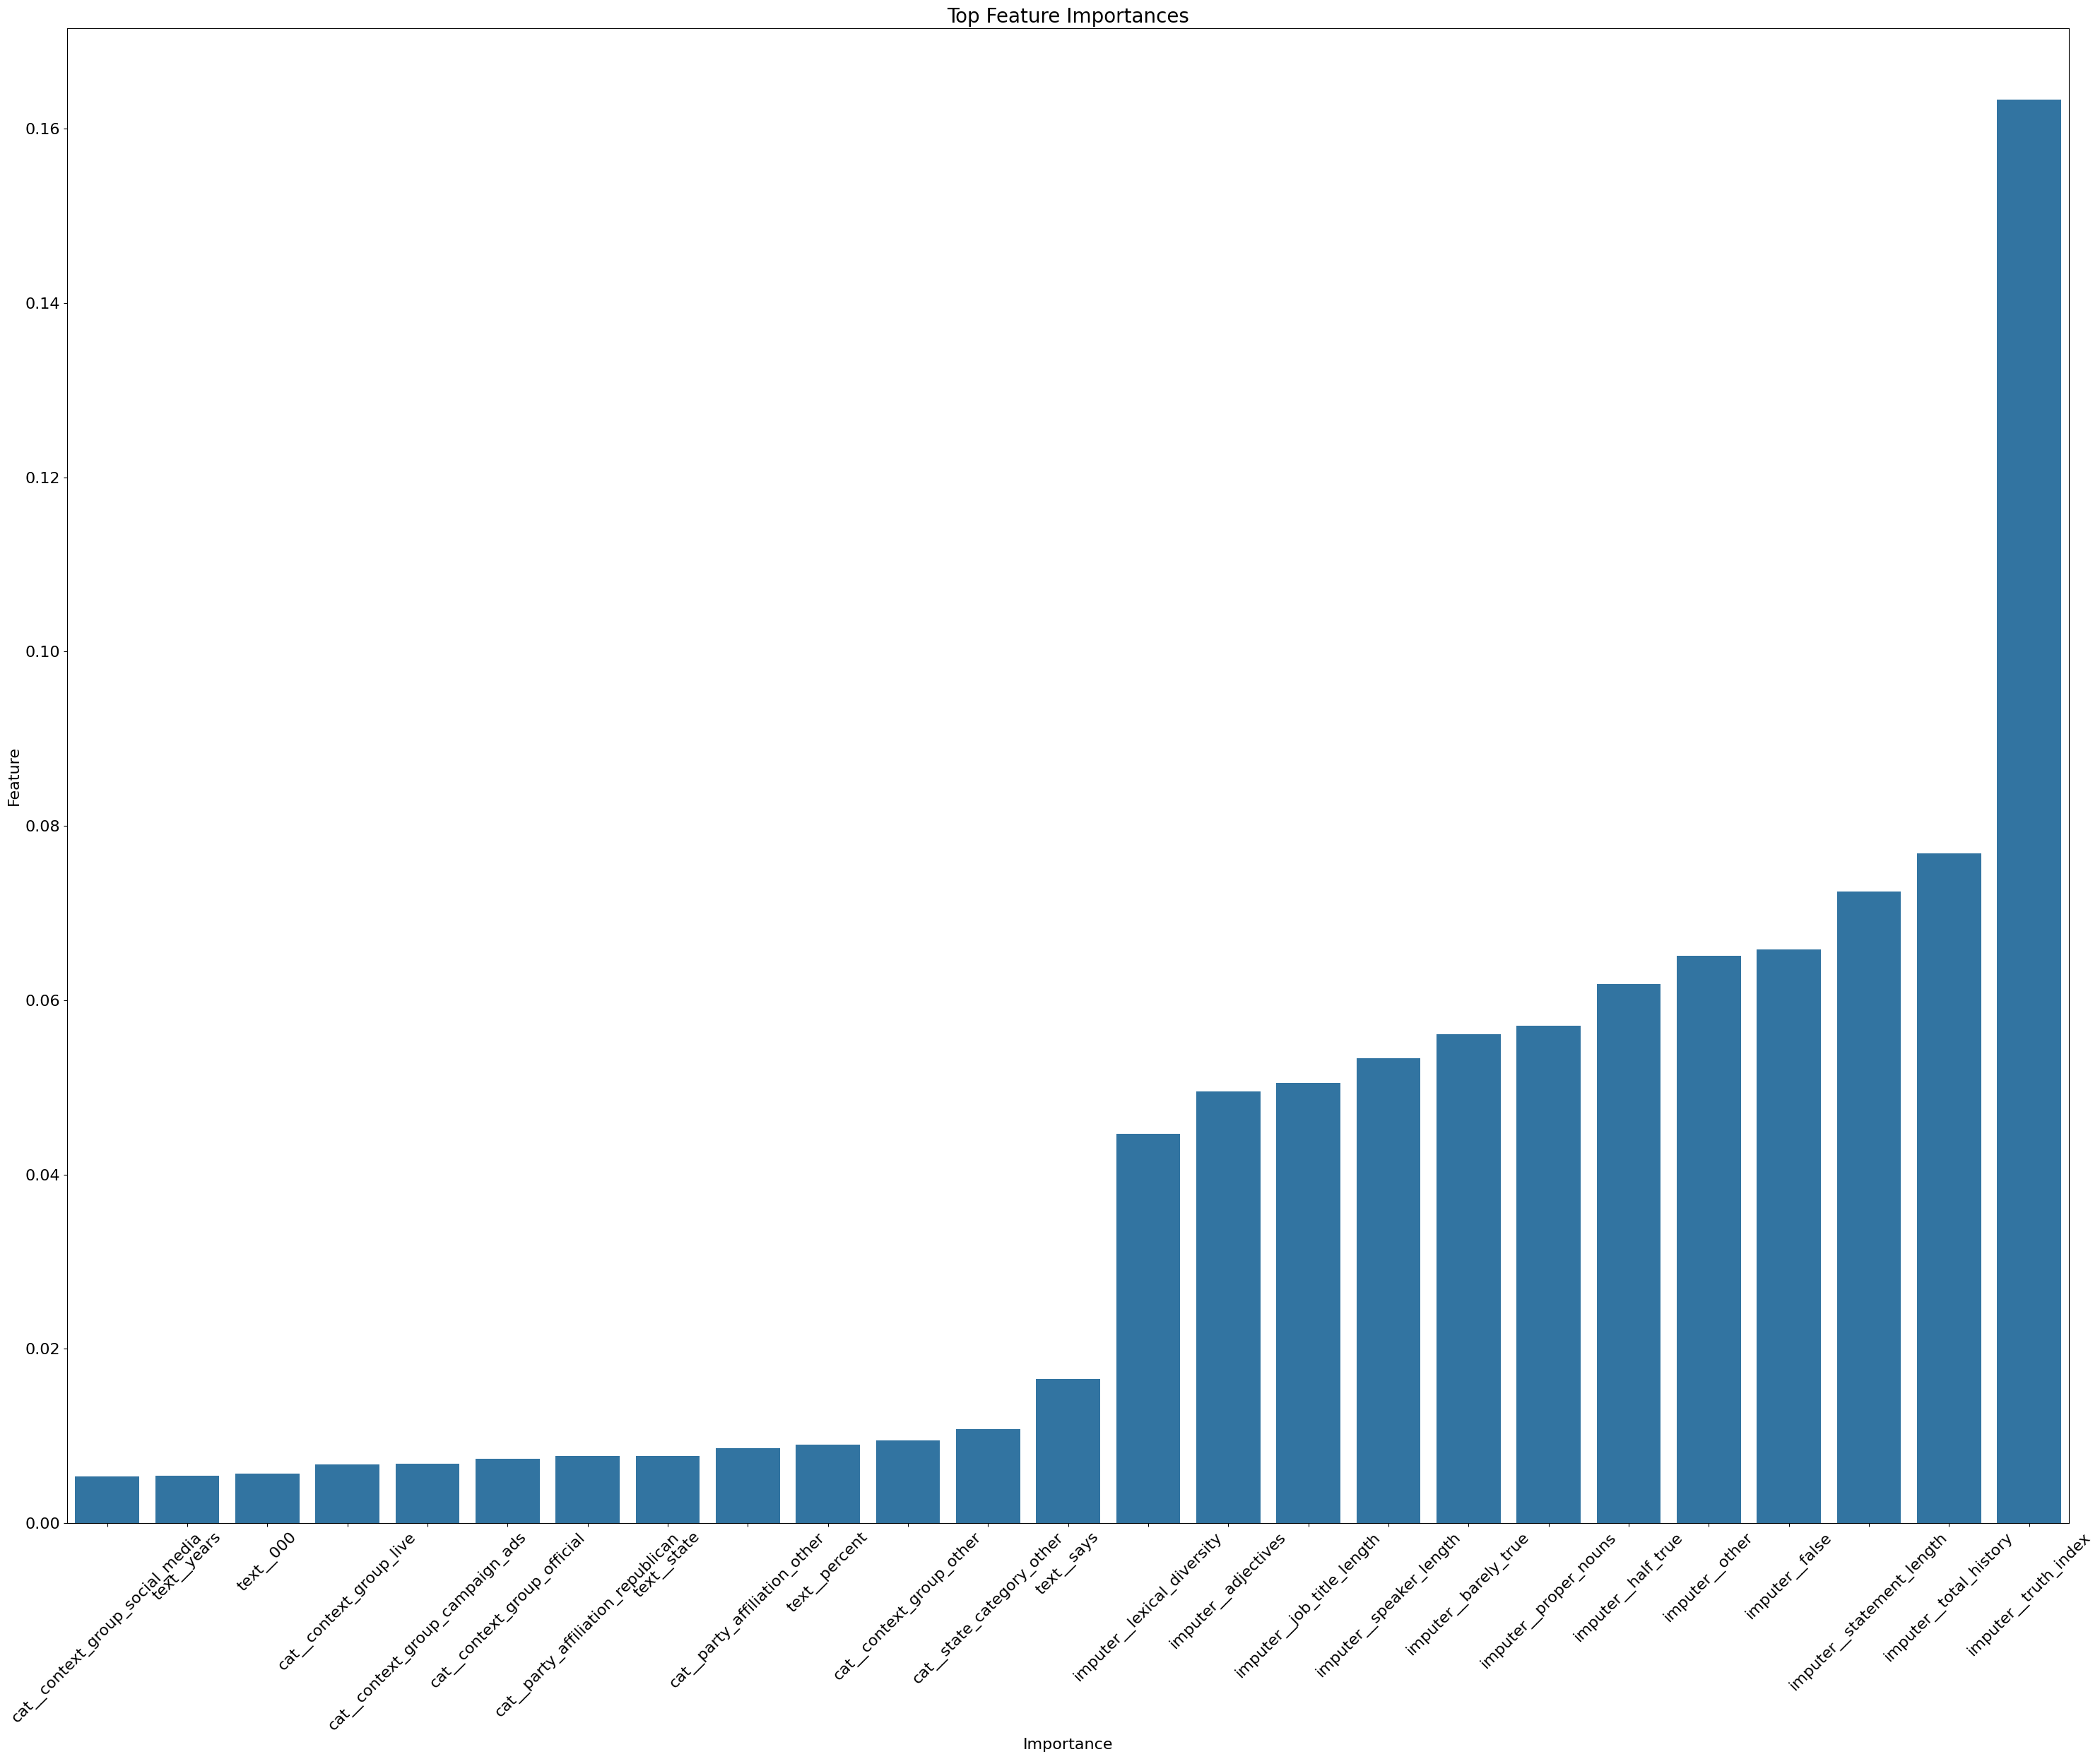

In [65]:
best_model = RandomForestClassifier(random_state=42, n_estimators=200, max_features=None, n_jobs=-1)
categorical_cols = ['party_affiliation', 'context_group', 'state_category']
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('mostly_true')
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(max_features=20, stop_words='english', ngram_range=(1, 2)), 'statement'),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop = 'first'), categorical_cols),
        ('imputer', SimpleImputer(strategy='median'), numerical_cols)
    ],
    remainder='drop'
)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', best_model)
])
model = pipeline.fit(X_combined, y_combined)
calculate_metrics(y_test, model.predict(X_test), "RandomForest", model)
plot_feature_importances(model)

We couldnt get better results, so we may have to stick to the model that does not use the statement

F1 Score: 0.618


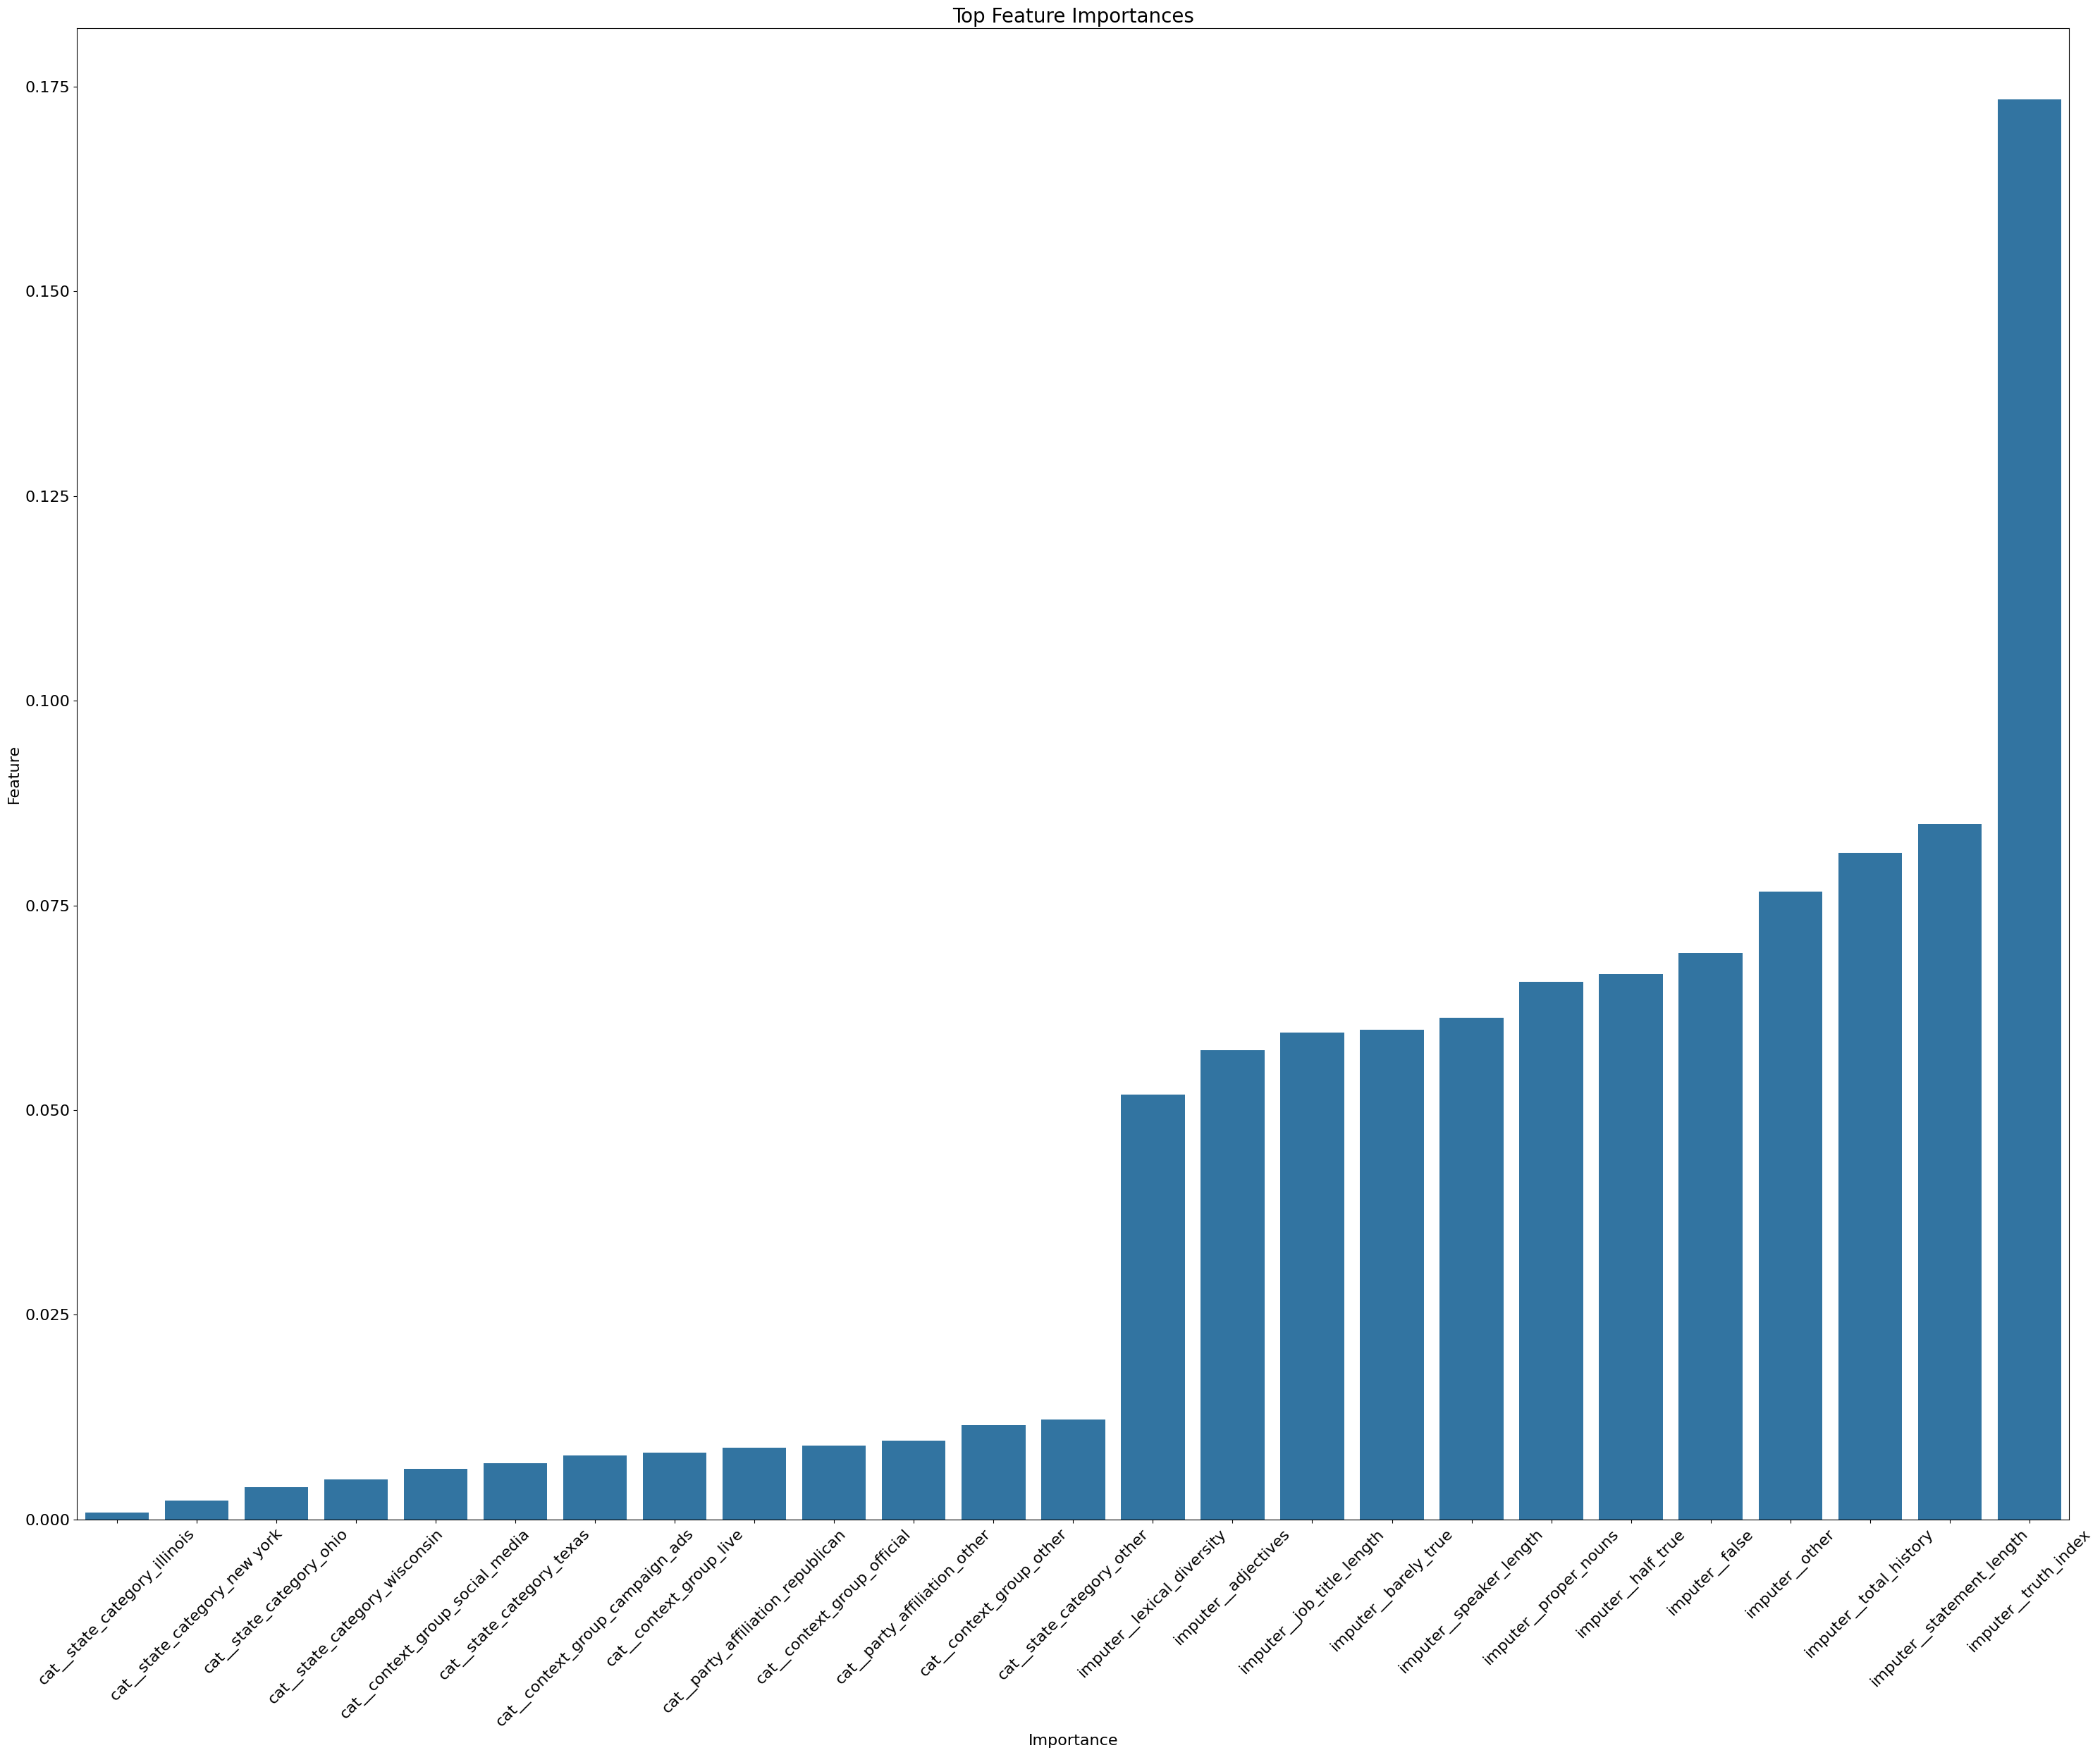

In [66]:
best_model = RandomForestClassifier(random_state=42, n_estimators=200, max_features=None, n_jobs=-1)
categorical_cols = ['party_affiliation', 'context_group', 'state_category']
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('mostly_true')
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop = 'first'), categorical_cols),
        ('imputer', SimpleImputer(strategy='median'), numerical_cols)
    ],
    remainder='drop'
)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', best_model)
])
model = pipeline.fit(X_combined, y_combined)
calculate_metrics(y_test, model.predict(X_test), "RandomForest", model)
plot_feature_importances(model)

Let us try different imputing method

F1 Score: 0.618


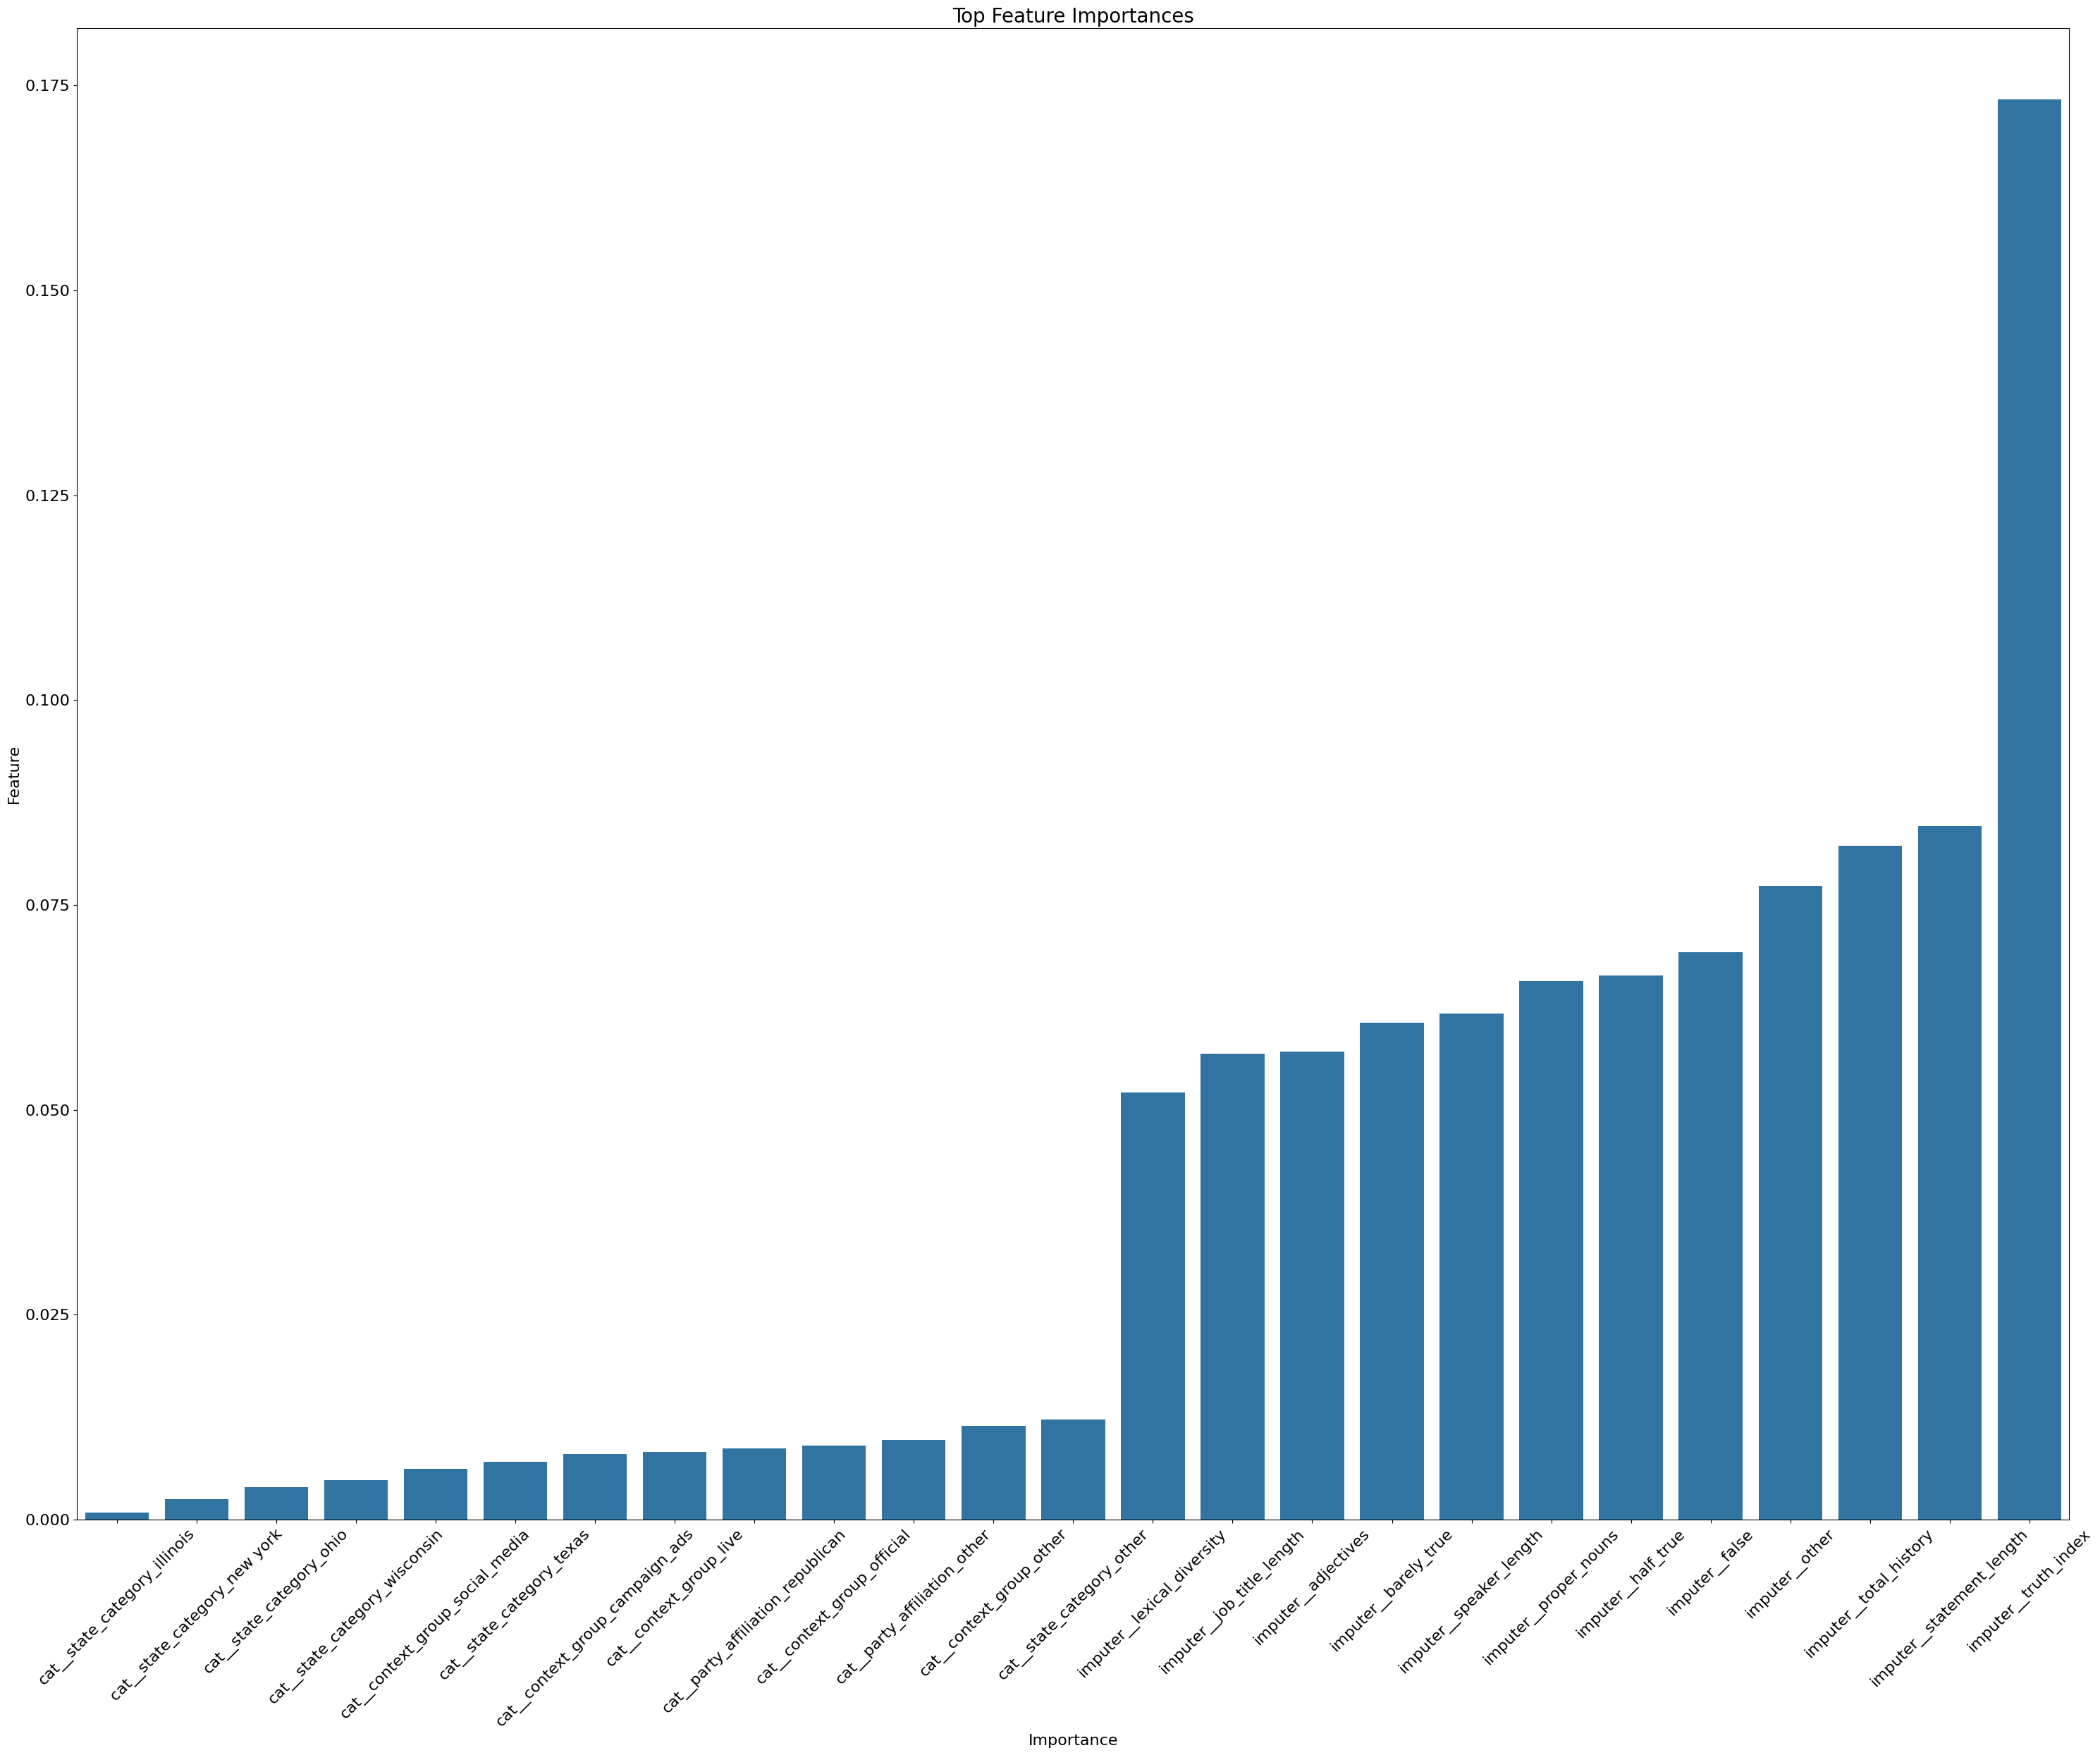

In [68]:
best_model = RandomForestClassifier(random_state=42, n_estimators=200, max_features=None, n_jobs=-1)
categorical_cols = ['party_affiliation', 'context_group', 'state_category']
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('mostly_true')
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop = 'first'), categorical_cols),
        ('imputer', SimpleImputer(strategy='constant', fill_value=0), numerical_cols)
    ],
    remainder='drop'
)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', best_model)
])
model = pipeline.fit(X_combined, y_combined)
calculate_metrics(y_test, model.predict(X_test), "RandomForest", model)
plot_feature_importances(model)

We got the same, so let us save what we have until this moment

In [69]:
save_to_excel(report)

F1 Score: 0.618


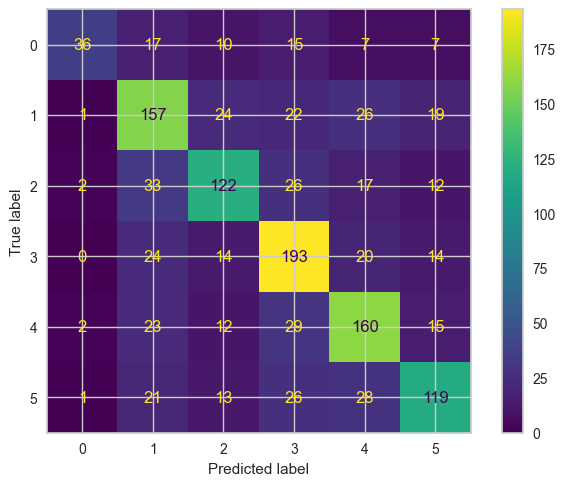

In [11]:
best_model = RandomForestClassifier(random_state=42, n_estimators=200, max_features=None, n_jobs=-1)
categorical_cols = ['party_affiliation', 'context_group', 'state_category']
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('mostly_true')
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop = 'first'), categorical_cols),
        ('imputer', SimpleImputer(strategy='constant', fill_value=0), numerical_cols)
    ],
    remainder='drop'
)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', best_model)
])
model = pipeline.fit(X_combined, y_combined)
y_pred = model.predict(X_test)
calculate_metrics(y_test, y_pred, "RandomForest", model)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

AttributeError: 'float' object has no attribute 'show'

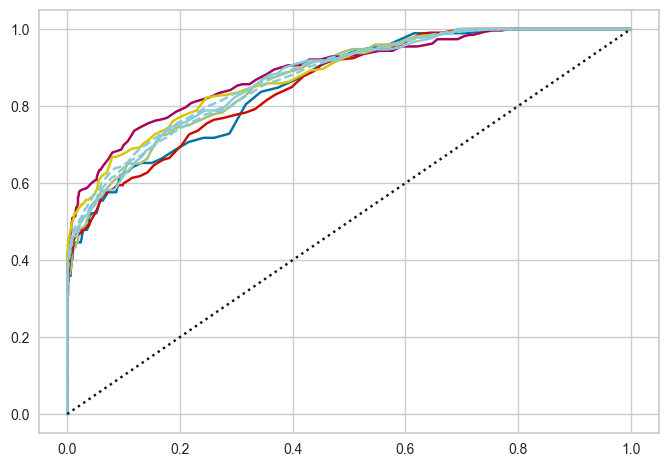

In [12]:
visualizer = ROCAUC(pipeline, classes=[0,1,2,3,4,5]).fit(X_train, y_train).score(X_test, y_test).show()